<h1><center>«Portfolio-Exam Part II» </center></h1>
<h2><center>MADS-MMS </center></h2>
<h3><center>Author: Tom Wüsten </center></h3>

### Abstract
This Online Retail II data set contains all the transactions occurring for a UK-based and registered, non-store online retail between 01/12/2009 and 09/12/2011.The company mainly sells unique all-occasion gift-ware. Many customers of the company are wholesalers. <br>

### Introduction
   
In today's world, companies are increasingly competing through globalisation. Companies need to have clear strategies to retain their existing customers. To do this, it is imperative to know the different types of customers. For successful implementation, it is imperative to pursue an individual marketing strategy for each type of customer. <br>
One approach for customer segmentation is offered by data mining methods. Data mining is a part of knowledge
discovery data which is an information extraction process that
is useful, not known before, and hidden from data [4]. Clustering is one of the methods of data mining and is particularly suitable for identifying groupings and patterns. Clustering is in the group of unsupervised learning that menas there are no target variables to predict. For customer segmentation, it means that segmentations can be created based on interactions and transactions with the companies. In this paper, clustering refers to a dataset of an online shop registered in the UK. The dataset was taken from the UCI Machine Learning Repository[1]. The data record depicts customer invoices. A good and useful method to get more information from invoice data is RFM (Recency, Frequency, Monetary). With this method, the customer's transaction data is transformed and grouped. From this, the recency: last visit by the customer, frequency: frequency of the purchase and the monetary: sales per one purchase can be determined. The RFM method offers a simple way of presenting the information obtained in an understandable manner. <br>
The aim of the paper is to create a customer segmentation using the RFM method in order to create specially tailored marketing campaigns and thus increase the sales of the online shop.[2][3]

### Outline
* [Data Cleansing](#1) <br>
* [Data Exploration](#2) <br>
    * [Time of product purchase](#20) <br>
    * [Sales by country](#21) <br>
    * [Return rate of the products](#22) <br>
    * [Product Analysis](#23) <br>
    * [Customer Overview](#24) <br>
* [Data Preparation](#3) <br>
* [Partitioning Clustering with K-means](#4) <br>
    * [Experiment K-Means cluster size k=3](#5) <br>
    * [Experiment K-Means clsuter size k=5](#6) <br>
* [Hierarchical CLustering](#7) <br>
    * [Experiment Hierarchical Clustering Cluster size k=2](#8) <br>
    * [Experiment Hierarchical Clustering Cluster size k=4](#9) <br>
* [Fuzzy Clustering](#10) <br>
    * [Experiment Fuzzy Clustering Cluster size k=3](#11) <br>
    * [Experiment Fuzzy Clustering Cluster size k=2](#12) <br>
* [Evaluation](#13) <br>

In [2]:
#Load Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from imp import reload
from functools import reduce
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from fcmeans import FCM

### Data Cleansing <a id='1'></a> <br>

#### Attribute Information: <br>

InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. <br>
StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. <br>
Description: Product (item) name. Nominal. <br>
Quantity: The quantities of each product (item) per transaction. Numeric. <br>
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. <br>
UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). <br>
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer. <br>
Country: Country name. Nominal. The name of the country where a customer resides. <br>

In [3]:
# Import Dataset
df1 = pd.read_excel('online_retail_II.xlsx', sheet_name = 0)
df2 = pd.read_excel('online_retail_II.xlsx', sheet_name = 1)
df = pd.concat([df1,df2], axis=0)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
print(df.shape)
df.drop_duplicates()
print(df.shape)

(1067371, 8)
(1067371, 8)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


In [6]:
df.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [7]:
df.shape

(1067371, 8)

In the following, the data set is examined for missing values. It can be seen that there are missing values for the Description and Customer ID features. <br>
For the feature Description, 0.41% of the values are missing. This is to be considered very low and, in my view, can be seen as a missing entry in the product database. <br>
For the Customer ID feature, 22.7% of all invoices do not have a customer ID. This leads to booking errors because no customer can be assigned to the invoice. <br>
For further consideration of the data, the data must be removed.

In [4]:
df_null = round(100*(df.isnull().sum())/len(df), 2)
df_null

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

In [5]:
customerID = df["Customer ID"].isnull()
customerID_ = df[customerID]
customerID_.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
263,489464,21733,85123a mixed,-96,2009-12-01 10:52:00,0.00,NaN,United Kingdom
283,489463,71477,short,-240,2009-12-01 10:52:00,0.00,NaN,United Kingdom
284,489467,85123A,21733 mixed,-192,2009-12-01 10:53:00,0.00,NaN,United Kingdom
470,489521,21646,NaN,-50,2009-12-01 11:44:00,0.00,NaN,United Kingdom
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom


In [6]:
quantity = df['Quantity'] < 0
quantity_ = df[quantity]
quantity_

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


When examining the item price, it is noticeable that certain items do not have a commodity price. <br> 
These calculations can lead to erroneous assumptions in further use. For this purpose, all invoices that have a price of 0 Sterling per item are removed.

In [7]:
price = df['Price'] == 0
price_ = df[price]
price_.head()
print(price_.shape)
price_1 = price_["StockCode"].unique()
price_1
check = df[df["StockCode"].isin(price_1)]["Price"] == 0
check.value_counts()

(6202, 8)


False    599316
True       6202
Name: Price, dtype: int64

In [8]:
price = df['Price'] != 0
price_ = df[price]
print(price_.head())
df_null_price = round(100*(price_.isnull().sum())/len(price_), 2)
df.dropna(inplace = True)
print(df_null_price)


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
Invoice         0.00
StockCode       0.00
Description     0.00
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.32
Country         0.00
dtype: float64


After the data cleansing the dataset is reduced to 824364 rows with 8 features.

In [9]:
df.shape

(824364, 8)

## Data Exploration <a id='2'></a> 

The data exploration discovers following aspects:
* [Time of product purchase](#20) <br>
* [Sales by country](#21) <br>
* [Return rate of the products](#22) <br>
* [Product Analysis](#23) <br>
* [Customer Analysis](#24) <br>




### Time of product purchase <a id='20'></a> 
In order to create an analysis of the point of purchase, additional information must be obtained from the feature InvoiceDate. <br>
The year, month, day of the week and hour are used for further analysis. In the following, we will examine how the online shop has developed over the years 2009-2011. <br> 
The number of orders is used for this purpose. Furthermore, we want to find out in which month, on which day of the week and in which hours most orders are placed.	

In [10]:
# Get extra Features out of the InvoiceDate
df['year'] = df['InvoiceDate'].dt.year
df['month'] = df['InvoiceDate'].dt.strftime("%b")
df['weekday'] = df['InvoiceDate'].dt.strftime("%a")
df['hour'] = df['InvoiceDate'].dt.hour
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,year,month,weekday,hour
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,Dec,Tue,7
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,Dec,Tue,7
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,Dec,Tue,7
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,Dec,Tue,7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,Dec,Tue,7


The plot "Distribution of invoices per year" shows the number of bills over the years 2009-2011. It can be seen that there was a strong increase in business in 2010.<br>
Furthermore, business remained similarly high in 2011. <br>
The plot "Distribution of invoices per month" shows the number of bills over the months. <br>
The plot shows that orders start to increase in September and reach a peak in November. <br>
Since it is an online shop, I would interpret this to mean that it is the Christmas business. <br>
In the remaining months from January to August, business is at the same level.

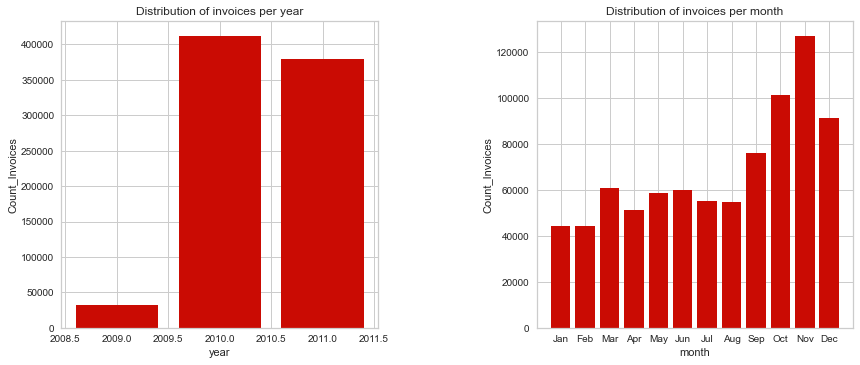

In [11]:
year = df.groupby("year", as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=0.9, wspace=0.5, hspace=None)
ax[0].bar(year["year"], year["Count_Invoices"], color='r')
# Bar Plot
ax[0].set_ylabel('Count_Invoices')
ax[0].set_xlabel('year')
ax[0].set_title('Distribution of invoices per year')
# 2. Plot
month = df.groupby([df['InvoiceDate'].dt.strftime('%m'),'month'], as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
ax[1].bar(month["month"], month["Count_Invoices"], color='r')
# Bar Plot
ax[1].set_ylabel('Count_Invoices')
ax[1].set_xlabel('month')
ax[1].set_title('Distribution of invoices per month')
# Show Plot
plt.show()

The plot "Distribution of invoices per weekday" shows the number of bills over the weekdays. <br>
A peak in orders can be seen on Thursday. A constant level of incoming goods can be seen on Monday, Tuesday, Wednesday and Sunday. <br>
On Friday, a decrease of 20% in purchases can be seen. But the most interesting thing is that there are no orders on Saturday. <br>
This seems very unusual and one would have to ask the person responsible for the data why there is no data or no orders on Saturday. <br>
The plot "Distribution of invoices per hour" shows the number of bills over the hours. <br>
The plot behaves like a gaussian distribution. With the assumption that most customers are wholesalers,  can assume that most purchases are made during business hours.

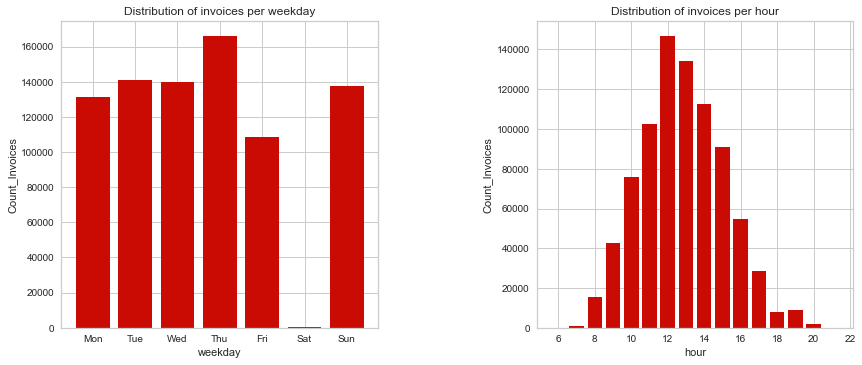

In [12]:
weekday = df.groupby([df['InvoiceDate'].dt.weekday,"weekday"], as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
fig, ax = plt.subplots(1, 2)
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=0.9, wspace=0.5, hspace=None)
ax[0].bar(weekday["weekday"], weekday["Count_Invoices"], color='r')
# Bar Plot
ax[0].set_ylabel('Count_Invoices')
ax[0].set_xlabel('weekday')
ax[0].set_title('Distribution of invoices per weekday')
# Second Plot
hour = df.groupby("hour", as_index= False).agg(Count_Invoices = ('Invoice', 'count'))
ax[1].bar(hour["hour"], hour["Count_Invoices"], color='r')
# Bar Plot
ax[1].set_ylabel('Count_Invoices')
ax[1].set_xlabel('hour')
ax[1].set_title('Distribution of invoices per hour')
# Show Plot
plt.show() 

### Sales by country <a id='21'></a> 
To measure sales by country, the sales volume per order must first be determined. To do this, the features Quantity and Price are multiplied. This result is in the new feature Cost per Invoice. <br>
The most turnover is made in the UK with 82.93%. The online shop also has small turnovers in EIRE (Irland), Netherland, <br> Germany and France. This countries come to a turnover of 11,21%. The rest 6% of the turnover is made around the world. 

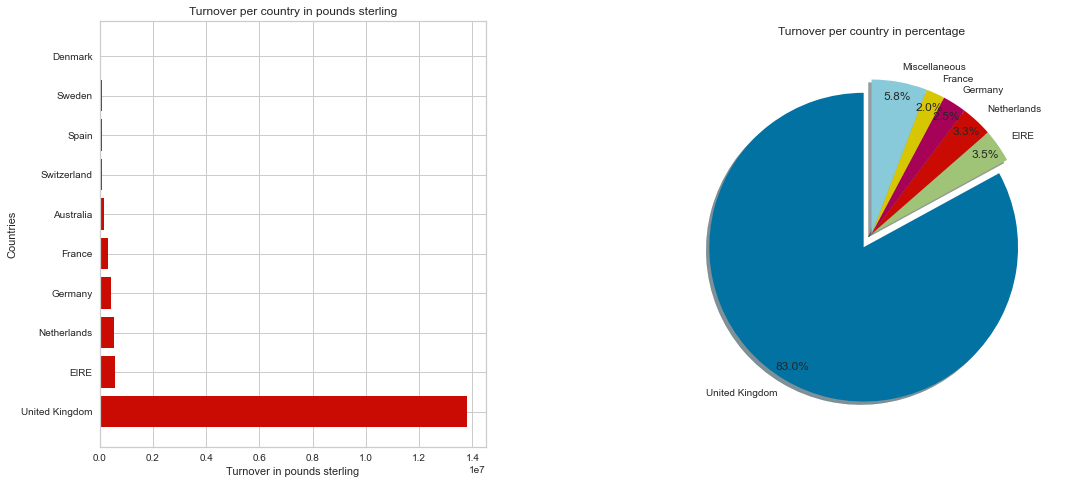

In [13]:
df['Cost Per Invoice'] = df['Quantity'] * df['Price']
top_ten_countries = df.groupby("Country", as_index= False)["Cost Per Invoice"].agg('sum').sort_values(by = "Cost Per Invoice",ascending= False).head(10)
# Figure Size
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
ax[0].barh(top_ten_countries["Country"], top_ten_countries["Cost Per Invoice"], color='r')
 
# Horizontal Bar Plot
ax[0].set_ylabel('Countries')
ax[0].set_xlabel('Turnover in pounds sterling')
ax[0].set_title('Turnover per country in pounds sterling')
# Second Plot
turnover_countries = df.groupby("Country", as_index= False)["Cost Per Invoice"].agg('sum').sort_values(by = "Cost Per Invoice",ascending= False)
turnover_countries["Sales_countries_percentage"] = round(100*(turnover_countries["Cost Per Invoice"])/sum(turnover_countries["Cost Per Invoice"]), 2)
Sales_countries_percentage = turnover_countries[turnover_countries.Sales_countries_percentage < 1.9].sum()
cost = turnover_countries[turnover_countries["Cost Per Invoice"] < 3.165047e+05].sum()
products = turnover_countries.Sales_countries_percentage > 1.9
turnover_countries = turnover_countries[products]
turnover_countries = turnover_countries.append(pd.DataFrame({'Country': ["Miscellaneous"], 'Cost Per Invoice': [cost["Cost Per Invoice"]], 'Sales_countries_percentage': [Sales_countries_percentage["Sales_countries_percentage"]]}))
turnover_countries
# Creating plot
explode = (0.1, 0, 0, 0,0,0)  # only "explode" the first slice (i.e. 'UK')
ax[1].pie(turnover_countries["Sales_countries_percentage"], explode=explode, labels= turnover_countries["Country"], autopct='%1.1f%%',  pctdistance=0.9,
        shadow=True, startangle=90)
ax[1].set_title('Turnover per country in percentage')
# Show Plot
plt.show()

### Return Rate <a id='22'></a> 
The two graphs show the most recalled products and the return rate across all orders. The return rate of 2.3% for all products is very low. <br> 
Returned orders are no longer taken into account for the further investigations because they affect the subsequent market segmentation.

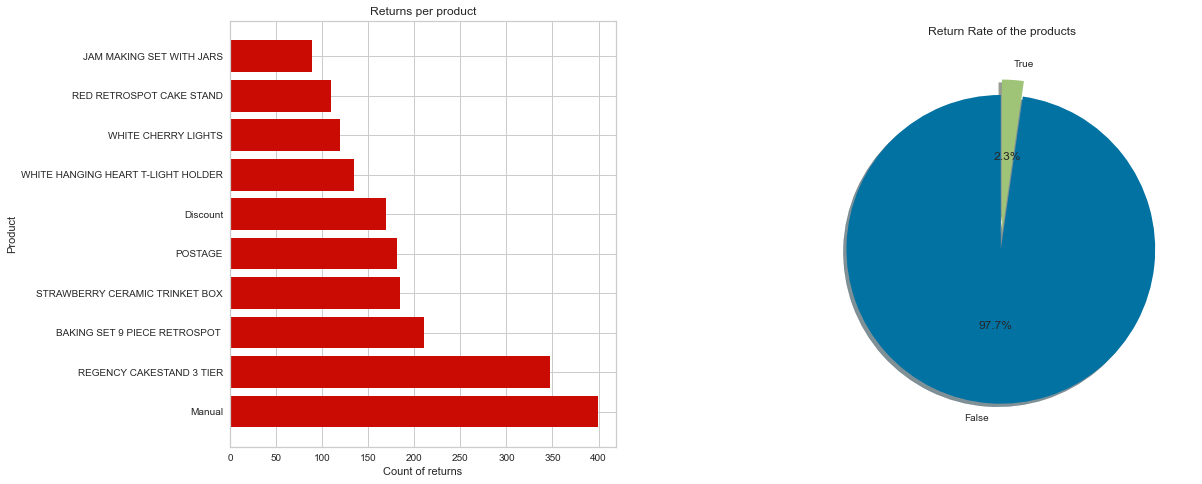

In [14]:
df["Return"] = df.Quantity <0
return_product = df[df.Return == True]
result = return_product.groupby("Description", as_index= False)["Invoice"].agg("count").sort_values(by = "Invoice", ascending= False).head(10)
#result.sort_values(by = "Invoice", ascending= False).head(10)
# Figure Size
fig, ax = plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
ax[0].barh(result["Description"], result["Invoice"], color='r')
 
# Horizontal Bar Plot
ax[0].set_ylabel('Product')
ax[0].set_xlabel('Count of returns')
ax[0].set_title('Returns per product')
# second
tmp = df["Return"].value_counts()
explode = (0.1,0)
ax[1].pie(tmp, labels= tmp.index,explode=explode, autopct='%1.1f%%',  pctdistance=0.5,
        shadow=True, startangle=90)
ax[1].set_title('Return Rate of the products')
# Show Plot
plt.show()
#Filter out returned products
return_product = df.Return == False
df = df[return_product]

### Best selling products <a id='23'></a>
When analysing the products, I first checked whether the number of stock codes was the same as the number of labels. <br>
This revealed that some products have different descriptions. This could be improved in the online shop. That's why I only use the stock codes for product analysis. <br>
The online shop has 4631 products, where none of the products take the biggest part in the sale.<br>
This can be seen in the following diagram, where I show the 10 best-selling products. <br> 
In this plot, the number of products sold is compared with the sales revenue per product of the 10 best-selling products. <br>
You can see that, for example, the product with the stock code 84077 is responsible for 1% of the number of goods sold, but only for 0.14% of the turnover per product. <br>
This shows that the number of products sold does not equal the turnover per product.

In [15]:
unique_Stockcode = len(df["StockCode"].unique())
unique_Description = len(df["Description"].unique())
print("There are "+ str(unique_Stockcode)+ " unique Stockcods and "+ str(unique_Description) + " Descriptions for Products." )

There are 4631 unique Stockcods and 5283 Descriptions for Products.


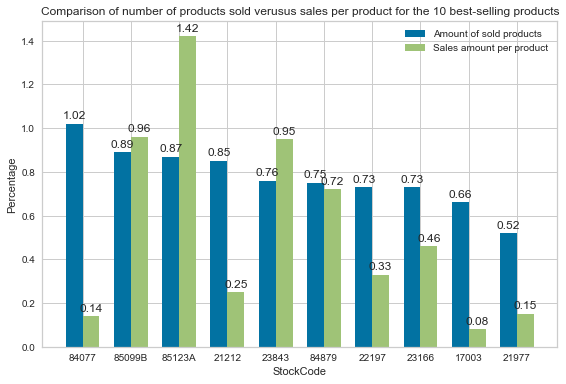

In [16]:
products = df.groupby(["StockCode"], as_index= False).agg(Count_item=('Quantity', 'sum'),Sales_product=('Cost Per Invoice','sum')).sort_values(by = "Count_item",ascending=False)
products["count_product_percentage"] = round(100*(products["Count_item"])/sum(products["Count_item"]), 2)
products["Sales in percenatge"] = round(100*(products["Sales_product"])/sum(products["Sales_product"]), 2)
products.head(10)
x = np.arange(len(products["count_product_percentage"].head(10)))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, products["count_product_percentage"].head(10), width, label='Amount of sold products')
rects2 = ax.bar(x + width/2, products["Sales in percenatge"].head(10), width, label='Sales amount per product')
#Titles
ax.set_ylabel('Percentage')
ax.set_xlabel('StockCode')
ax.set_title('Comparison of number of products sold verusus sales per product for the 10 best-selling products')
ax.set_xticks(x, products["StockCode"].head(10))
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
#Plot
plt.show()

### Customer Analysis <a id='24'></a>
The online shop has 5881 customers. The 10 best customers alone are responsible for 15.93% of the turnover. <br>
In this analysis, only an overview of the customers is to be gained. The clustering will then go into detail about types of customers.

The Online shop has 5881 customer and the top 10 customer are responsible for 15.93% of the turnover.


C:\Users\wuest\AppData\Local\Temp/ipykernel_11064/864251928.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result["Customer ID"] = result["Customer ID"].astype(str)


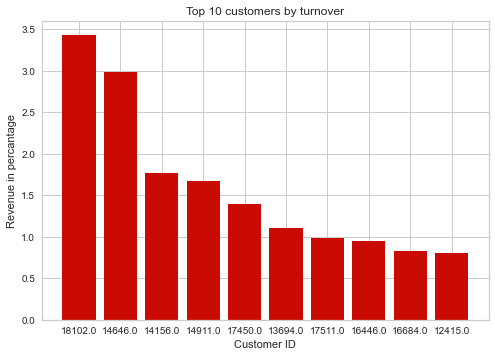

In [17]:
unique_customer = len(df["Customer ID"].unique())
customer = df.groupby("Customer ID", as_index= False).agg(Sales=('Cost Per Invoice', 'sum')).sort_values(by = "Sales",ascending=False)
customer["Sales in Percentage"] = round(100*(customer.Sales)/np.sum(customer.Sales), 2)
result = customer.head(10)
print("The Online shop has " + str(unique_customer)+ " customer and the top 10 customer are responsible for " + str(np.sum(result["Sales in Percentage"])) +"% of the turnover.")
result["Customer ID"] = result["Customer ID"].astype(str) 
plt.bar(result["Customer ID"], result["Sales in Percentage"], color='r')

# Horizontal Bar Plot
plt.xlabel('Customer ID')
plt.ylabel('Revenue in percantage')
plt.title('Top 10 customers by turnover')
plt.show()


### Data Preparation <a id='3'></a> 

After the Data Expolration we found out that the most turnover is made in the UK. Furthermore, we have seen that not one product is bought frequently, <br>
but that all products are bought in similar numbers. In addition, it became clear that a small number of customers are responsible for a large share of the online shop. <br>
The Recency Frequency Monetary (RFM) model is often used for customer segmentation in marketing. This model allows information about customer behaviour to be obtained. <br>
* Recency: How recently customer made a buy. <br>
* Frequency: How often customer buys. <br>
* Monetary: How much amount customer buys <br>

In Data Preparation, the input data frame is adjusted so that it only consists of CustomerId, Recency, Frequency and Monetary. <br>
 This data frame forms the basis for the subsequent clustering.

In [18]:
# df_time = df[(df.year == 2009) ]
df_a = df.groupby(["Invoice","Customer ID", "InvoiceDate"], as_index= False).agg(Items = ("StockCode","nunique"), Amount_of_Products= ("Quantity", "sum"),Total_Price=("Cost Per Invoice","sum"))
df_a.sort_values(by = "InvoiceDate", ascending= True).head()
#Calculation Recency
df_recency = df_a.groupby(by='Customer ID',
                        as_index=False)['InvoiceDate'].max()
df_recency.columns = ['Customer ID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
# Calculation Frequency
frequency_df = df_a.drop_duplicates().groupby(
    by=['Customer ID'], as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['Customer ID', 'Frequency']
# Calculation Monetary
monetary_df = df_a.groupby(by='Customer ID', as_index=False)['Total_Price'].sum()
monetary_df.columns = ['Customer ID', 'Monetary']
# Combing all attributes
all_df = [df_recency,frequency_df,monetary_df]
rfm_df = reduce(lambda left,right: pd.merge(left,right,on='Customer ID'), all_df)
rfm_df = rfm_df.set_index('Customer ID')
rfm_df = rfm_df[["Recency",'Frequency','Monetary']]
rfm_df.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,325,12,77556.46
12347.0,1,8,5633.32
12348.0,74,5,2019.40
12349.0,18,4,4428.69
12350.0,309,1,334.40


In [19]:
def view_distribution(df):
    sns.boxplot(data=df)
    plt.xticks(rotation=90)
    plt.show

After transforming the initial data set, let us first look at the distribution of features in the boxplot. The boxplot illustrates very well whether the data have outliers. It is very easy to see that the feature Monetary has 2 outliers. The first step when outliers occur is to ask the domain expert whether the data are real. In this task I assume that they are outliers. For later clustering, it is important that the outliers are removed.

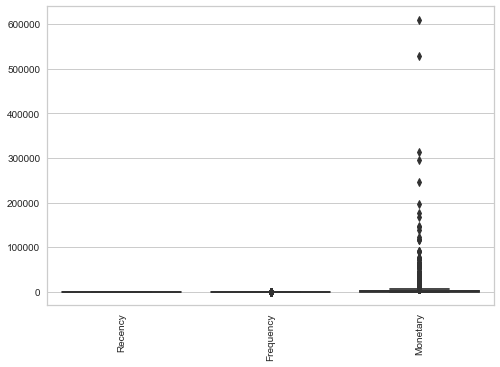

In [20]:
# Creating plot
view_distribution(rfm_df)


The interquartile range (IQR) is a measure of statistical dispersion, which is the spread of the data. The IQR method can be used to identify outliers. To do this, a 'fence' is created outside Q1 and Q3. All values outside this fence are considered outliers. To create this fence, we take 1.5 times the IQR and subtract this value from Q1 and add it to Q3. This gives us the minimum and maximum fence posts against which we compare each observation. Observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. 

In [21]:
# UDF to remove outlier
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

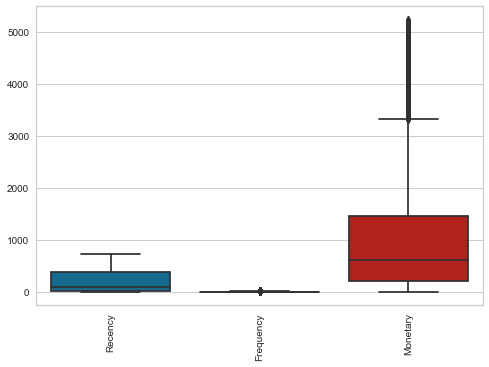

In [22]:
df_IQR = remove_outlier_IQR(rfm_df)
df_IQR.fillna(0,inplace=True)
view_distribution(df_IQR)

Since the values are in different units and scales, the values must be standardised.

In [23]:
rfm_df_copy = df_IQR
#StandartScaler
scaler = StandardScaler()
# transform data
rfm_df_sc = pd.DataFrame(scaler.fit_transform(df_IQR.values), columns=rfm_df.columns, index=rfm_df.index)
rfm_df_sc.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,0.594598,2.300938,-0.896115
12347.0,-0.952264,1.186084,-0.896115
12348.0,-0.603743,0.349944,0.824729
12349.0,-0.871102,0.071230,2.877820
12350.0,0.518209,-0.764910,-0.611154


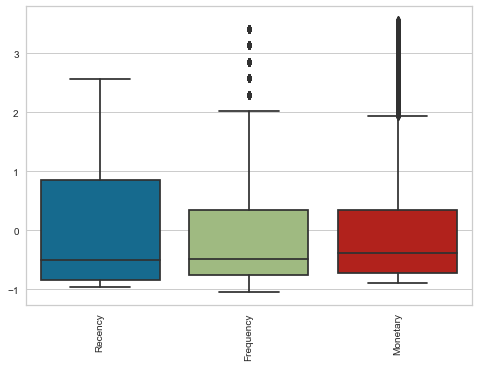

In [24]:
# Creating plot
view_distribution(rfm_df_sc)

In [25]:
# Create evaluation dataframe 
evaluation_df = pd.DataFrame({'Clustering':[], 'silhouette_score':[],'best_cluster_size':[], 'cluster_size':[],'labeled_data':[]})

In [58]:
def plot_clusters_with_centers(model, X,i, measure, linkage):
    if model == "KMeans":
        clf=KMeans(n_clusters=i, random_state=1)
        y_pred = clf.fit_predict(X)
        fig, ax = plt.subplots(1,3)
        plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
        for i in range(0,len(np.unique(y_pred))):
            ax[0].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        # Horizontal Bar Plot
        ax[0].set_ylabel('Monetary')
        ax[0].set_xlabel('Recency')
        ax[0].set_title('Plot 1: Clustering View Recency vs Monetary')
        ax[0].legend()
        # second
        for i in range(0,len(np.unique(y_pred))):
            ax[1].scatter(X.iloc[y_pred==i, 1], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        ax[1].set_ylabel('Monetary')
        ax[1].set_xlabel('Frequency')
        ax[1].set_title('Plot 2: Clustering View Frequency vs Monetary')
        ax[1].legend()
        for i in range(0,len(np.unique(y_pred))):
            ax[2].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 1], c=colors[i], label=i, marker = '.')
        ax[2].set_ylabel('Recency')
        ax[2].set_xlabel('Frequency')
        ax[2].set_title('Plot 3: Clustering View Frequency vs Monetary')
        ax[2].legend()
        # Show Plot
        plt.show()
    elif model == "agg":
        clf=cluster.AgglomerativeClustering(n_clusters=i, affinity=measure, linkage=linkage, compute_distances=True)
        y_pred = clf.fit_predict(X)
        fig, ax = plt.subplots(1,3)
        plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
        for i in range(0,len(np.unique(y_pred))):
            ax[0].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        # Horizontal Bar Plot
        ax[0].set_ylabel('Monetary')
        ax[0].set_xlabel('Recency')
        ax[0].set_title('Plot 1: Clustering View Recency vs Monetary')
        ax[0].legend()
        # second
        for i in range(0,len(np.unique(y_pred))):
            ax[1].scatter(X.iloc[y_pred==i, 1], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        ax[1].set_ylabel('Monetary')
        ax[1].set_xlabel('Frequency')
        ax[1].set_title('Plot 2: Clustering View Frequency vs Monetary')
        ax[1].legend()
        for i in range(0,len(np.unique(y_pred))):
            ax[2].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 1], c=colors[i], label=i, marker = '.')
        ax[2].set_ylabel('Recency')
        ax[2].set_xlabel('Frequency')
        ax[2].set_title('Plot 3: Clustering View Frequency vs Monetary')
        ax[2].legend()
        # Show Plot
        plt.show()
    elif model == "fcm":
        fcm = FCM(n_clusters=i)
        fcm.fit(X.to_numpy())
        y_pred = fcm.predict(X.to_numpy())
        fig, ax = plt.subplots(1,3)
        plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
        for i in range(0,len(np.unique(y_pred))):
            ax[0].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        # Horizontal Bar Plot
        ax[0].set_ylabel('Monetary')
        ax[0].set_xlabel('Recency')
        ax[0].set_title('Plot 1: Clustering View Recency vs Monetary')
        ax[0].legend()
        # second
        for i in range(0,len(np.unique(y_pred))):
            ax[1].scatter(X.iloc[y_pred==i, 1], X.iloc[y_pred==i, 2], c=colors[i], label=i, marker = '.')
        ax[1].set_ylabel('Monetary')
        ax[1].set_xlabel('Frequency')
        ax[1].set_title('Plot 2: Clustering View Frequency vs Monetary')
        ax[1].legend()
        for i in range(0,len(np.unique(y_pred))):
            ax[2].scatter(X.iloc[y_pred==i, 0], X.iloc[y_pred==i, 1], c=colors[i], label=i, marker = '.')
        ax[2].set_ylabel('Recency')
        ax[2].set_xlabel('Frequency')
        ax[2].set_title('Plot 3: Clustering View Frequency vs Monetary')
        ax[2].legend()
        # Show Plot
        plt.show()

In [81]:
def calculate_silhouette_score1(model, k_min,k_max,df,measure,linkage,):
    silhouettes=[]
    evaluation_df=pd.DataFrame()
    i = k_min
    if model == "KMeans":
        for i in range(k_min,k_max+1):   
            clf=KMeans(n_clusters=i, random_state=1) # <- by default, this runs k-means++, starting over 10 times, reporting the best result
            y_pred = clf.fit_predict(df)
            evaluation_df=evaluation_df.append(pd.DataFrame({'Clustering':[model],"Cluster size":[i], 'Silhouette Score':[silhouette_score(df,y_pred)]}),ignore_index=True)
            silhouettes.append(silhouette_score(df,y_pred))        
    elif model == "agg":
        for i in range(k_min,k_max+1): 
            clf=cluster.AgglomerativeClustering(n_clusters=i, affinity=measure, linkage=linkage, compute_distances=True)
            y_pred = clf.fit_predict(df)
            evaluation_df=evaluation_df.append(pd.DataFrame({'Clustering':[model],"Cluster size":[i], 'Silhouette Score':[silhouette_score(df,y_pred)]}),ignore_index=True)
            silhouettes.append(silhouette_score(df,y_pred))
    elif model == "fcm":
        for i in range(k_min,k_max+1): 
            fcm = FCM(n_clusters=i)
            fcm.fit(df.to_numpy())
            fcm_labels = fcm.predict(df.to_numpy())
            evaluation_df=evaluation_df.append(pd.DataFrame({'Clustering':[model],"Cluster size":[i], 'Silhouette Score':[silhouette_score(df,fcm_labels)]}),ignore_index=True)
            silhouettes.append(silhouette_score(df,fcm_labels))      
    return evaluation_df, silhouettes

In [28]:
def calculate_silhouette_score(model, k_min,k_max,df,measure,linkage,):
    silhouettes=[]
    i = k_min
    if model == "KMeans":
        for i in range(k_min,k_max+1):   
            clf=KMeans(n_clusters=i, random_state=1) # <- by default, this runs k-means++, starting over 10 times, reporting the best result
            y_pred = clf.fit_predict(df)
            silhouettes.append(silhouette_score(df,y_pred))        
    elif model == "agg":
        for i in range(k_min,k_max+1): 
            clf=cluster.AgglomerativeClustering(n_clusters=i, affinity=measure, linkage=linkage, compute_distances=True)
            y_pred = clf.fit_predict(df)
            silhouettes.append(silhouette_score(df,y_pred))
    elif model == "fcm":
        for i in range(k_min,k_max+1): 
            fcm = FCM(n_clusters=i)
            fcm.fit(rfm_df_sc.to_numpy())
            fcm_labels = fcm.predict(rfm_df_sc.to_numpy())
            silhouettes.append(silhouette_score(df,fcm_labels))      
    return evaluation_df, silhouettes

In [71]:
def plot_silhouette_score(k_min,k_max,silhouette):
    plt.xlabel('k')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Coefficent for different cluster size k')
    plt.plot(range(k_min,k_max+1), silhouette)
    return plt.show()

In [30]:
def plot_elbow_method(data,min, max):
    sse = []
    for k in range(min,max+1):
        clf = KMeans(n_clusters=k, random_state=1)
        clf.fit(data)
        sse.append(clf.inertia_)

    #Elbow Method    
    plt.plot(sse, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.show()

In [31]:
def plot_silhouette_score_elbow(min,max,silhouette,data):
    f, axes = plt.subplots(1, 2)
    plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Silhouette Coefficient')
    axes[0].plot(range(k_min,k_max+1), silhouette)
    axes[0].set_title('Silhouette Coefficent for different cluster size k')
    #elbow method
    sse = []
    for k in range(min,max+1):
        clf = KMeans(n_clusters=k, random_state=1)
        clf.fit(data)
        sse.append(clf.inertia_)

    #Elbow Method    
    axes[1].plot(sse, 'bx-')
    axes[1].set_xlabel('Values of K')
    axes[1].set_ylabel('Distortion')
    axes[1].set_title('The Elbow Method using Distortion')
    plt.show()


In [32]:
def create_boxplot(df):
    f, axes = plt.subplots(1, 3)
    plt.subplots_adjust(left=None, bottom=None, right=1.8, top=1.2, wspace=0.5, hspace=None)
    sns.boxplot(x='cluster', y='Frequency', data=df, ax = axes[0]);
    sns.boxplot(x='cluster', y='Monetary',data=df,ax = axes[1]);
    sns.boxplot(x='cluster', y='Recency',data=df,ax = axes[2]);

In [33]:
def calculate_kmeans(data, clustersize):
    clf=KMeans(n_clusters=clustersize, random_state=1) # <- by default, this runs k-means++, starting over 10 times, reporting the best result
    y_pred = clf.fit_predict(data)
    return clf

In [34]:
def visualize_silhouette_score(kmeans,color,X):
    visualizer = SilhouetteVisualizer(kmeans, colors=color, is_fitted=True)
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.finalize()
    print(visualizer.silhouette_samples_)
    print(f'Silhoutte score: {visualizer.silhouette_score_}')
    #visualizer.poof(outpath="3.5_sil.jpg")
    return visualizer.show()        # Finalize and render the figure

In [35]:
def calculate_hierach_cluster(data, clustersize, measure, linkage):
    clf=cluster.AgglomerativeClustering(n_clusters=clustersize, affinity=measure, linkage=linkage, compute_distances=True)
    y_pred = clf.fit_predict(data)
    return clf

In [36]:
def plot_silhouette_score_agg(k_min,k_max,silhouette,linkage,measure):
    reload(plt)
    plt.xlabel('k')
    plt.ylabel('Silhouette Coefficient')
    plt.plot(range(k_min,k_max+1), silhouette)
    plt.title(f'Distance {measure} and Linkage {linkage}')
    return plt.show()

In [37]:
def create_linkage(agg):
    n_samples = len(agg.labels_)
    counts = np.zeros(agg.children_.shape[0])
    for i, merge in enumerate(agg.children_):
        current_count = 0
        #print (i, merge)
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([agg.children_, agg.distances_,counts]).astype(float)
    return linkage_matrix

In [38]:
def create_linkage(agg):
    n_samples = len(agg.labels_)
    counts = np.zeros(agg.children_.shape[0])
    for i, merge in enumerate(agg.children_):
        current_count = 0
        #print (i, merge)
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([agg.children_, agg.distances_,counts]).astype(float)
    return linkage_matrix

In [39]:
def agglomerate(measure, cluster_size, linkage_type, df):
    agg = cluster.AgglomerativeClustering(cluster_size, affinity=measure, linkage= linkage_type, compute_distances=True)
    labels = agg.fit_predict(df)
    rfm_df_copy["cluster"] = agg.labels_
    distribution = rfm_df_copy['cluster'].value_counts()
    print('Cluster distribution:')
    print(f'Distance {measure} and Linkage {linkage_type}')
    print(distribution)
    plt.figure(figsize=(8,5))
    cols=['red', 'green', 'blue', 'violet', 'orange']
    for i in range(0,len(np.unique(labels))):
        plt.scatter(df.iloc[labels==i, 0], df.iloc[labels==i, 2], c=cols[i], label=i, marker = '.')
        plt.ylabel('Monetary')
        plt.xlabel('Recency')
        plt.title(f'Clustering View Recency vs Monetary for 'f'Distance {measure} and Linkage {linkage_type}')
        plt.legend()
    hierarchy.set_link_color_palette(['red', 'green', 'blue', 'violet', 'orange'])
    plt.figure(figsize=(18,5))
    if str(measure).__contains__("function"):
        measure = "Pearson"
    dendrogram(
        create_linkage(agg),
        color_threshold=agg.distances_[-cluster_size + 1], #use agg.distances[-desired amount of cluster + 1] for coloring
        orientation='left',
        labels=df.index,
        leaf_rotation=0)
    plt.title(f'Distance {measure} and Linkage {linkage_type}')
    #plt.savefig(f'decathlon_dendrogram_{measure}_{linkage_type}.pdf')
    plt.show()

In [56]:
def show_dendogram(measure, cluster_size, linkage_type, df,i): 
    agg = cluster.AgglomerativeClustering(cluster_size, affinity=measure, linkage= linkage_type, compute_distances=True)
    labels = agg.fit_predict(df)
    rfm_df_copy["cluster"] = agg.labels_
    distribution = rfm_df_copy['cluster'].value_counts()
    print('Cluster distribution:')
    print(f'Distance {measure} and Linkage {linkage_type}')
    print(distribution)
    hierarchy.set_link_color_palette(['red', 'green', 'blue', 'violet', 'orange'])
    plt.figure(figsize=(18,5))
    if str(measure).__contains__("function"):
        measure = "Pearson"
    dendrogram(
        create_linkage(agg),
        color_threshold=agg.distances_[-cluster_size + 1], #use agg.distances[-desired amount of cluster + 1] for coloring
        orientation='left',
        labels=df.index,
        leaf_rotation=0)
    plt.title(f'Dendogram {i}: Distance {measure} and Linkage {linkage_type}')
    #plt.savefig(f'decathlon_dendrogram_{measure}_{linkage_type}.pdf')
    plt.show()

In [83]:
def calculate_fcm_cluster(data, clustersize):
    fcm = FCM(n_clusters=clustersize)
    fcm.fit(data.to_numpy())
    fcm_labels = fcm.predict(data.to_numpy())
    return fcm_labels

### Partitioning Clustering with K-means <a id='4'></a> 
The aim is to use K-Means clustering to identify patterns in customer types. The RFM dataset is used as a basis. <br>
The first step in K-Menas clustering is to find out what the best number of clusters k is. There are several methods to do this. <br>
In the following, the Silhouette method and the Elbow method are used. The average silhouette width provides an evaluation of
clustering validity, and might be used to select an ‘appropriate’ number of clusters.[ 34] <br>
Elbow method is a method which looks at the percentage of variance explained as a function of the number of clusters. <br>
This method exists upon the idea that one should choose a number of clusters so that adding another cluster doesn't give much better modelling of the data. <br> The percentage of variance explained by the clusters is plotted against the number of clusters.  <br> 
The first clusters will add much information but at some point the marginal gain will drop dramatically and gives an angle in the graph. <br>
The correct „k‟ i.e. number of clusters is chosen at this point, hence the "elbow criterion". <br>
The idea is that Start with K=2, and keep increasing it in each step by 1, calculating your clusters and the cost that comes with the training. <br> 
At some value for K the cost drops dramatically, and after that it reaches a plateau when you increase it further. This is the K value you want.[20] 

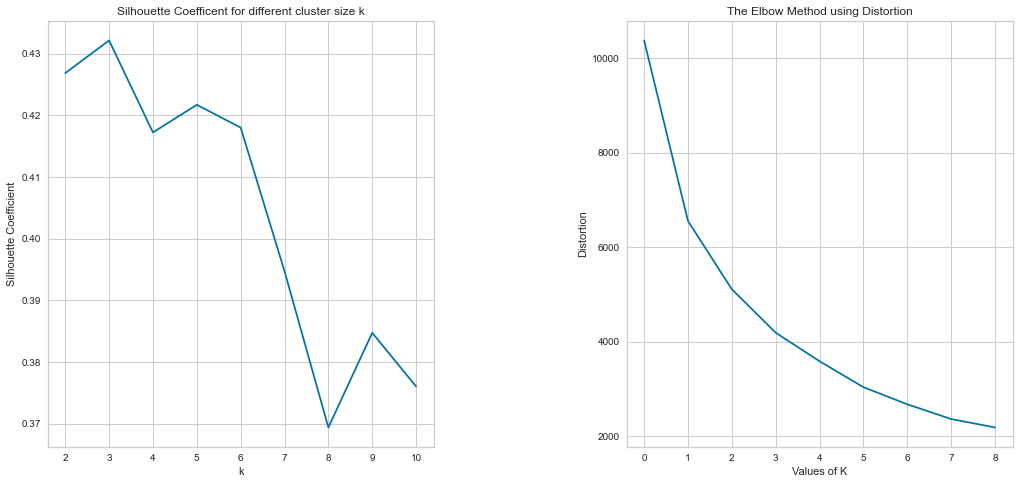

In [39]:
k_min = 2
k_max = 10
evaluation_df_k_means, silhouette = calculate_silhouette_score1("KMeans",k_min,k_max,rfm_df_sc,'','')
plot_silhouette_score_elbow(k_min,k_max,silhouette,rfm_df_sc)

The result of silhouette plot shows that best score can be reached for k=2,3,5. Therefore, in the following 2 experiments are set up for cluster sizes 3 and 5. Since the Silouette Score for 5 is similar to 2, k=5 is used because a higher cluster size enables better customer classification. The Elbow method shows that between k=2 and k=3 the Elbow criterion is met and this is the best classification for the data. This agrees with the result of the Silhouettes plot.

In [40]:
evaluation_df_k_means

,Clustering,Cluster size,Silhouette Score
0,KMeans,2,0.426865
1,KMeans,3,0.432166
2,KMeans,4,0.417246
3,KMeans,5,0.421728
4,KMeans,6,0.418035
5,KMeans,7,0.394742
6,KMeans,8,0.369396
7,KMeans,9,0.384740
8,KMeans,10,0.376051


For the evaluation of all experiments, the type of clustering is recorded with the Silhouette score for the selected experiments.

In [41]:
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['K-Means'], 'silhouette_score':[0.432], 'best_cluster_size':[3], 'cluster_size':[3]}),ignore_index=True)
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['K-Means'], 'silhouette_score':[0.421], 'best_cluster_size':[3], 'cluster_size':[5]}),ignore_index=True)

### Experiment K-Means cluster size k=3 <a id='5'></a> 
The first examination of clustering should be carried out with the K-Means algorithm with a cluster size of 3, because this had achieved the highest silhouette score. <br>
The three figures below show the clustering achieved for the three features: Recency, Frequency and Monetary. <br>
Especially plot 1&3 show a good structure of clusters. In the second plot, the points of cluster 1 overlap with the other clusters. <br>
In the further course of the experiment, the clusters are examined in the box plot.

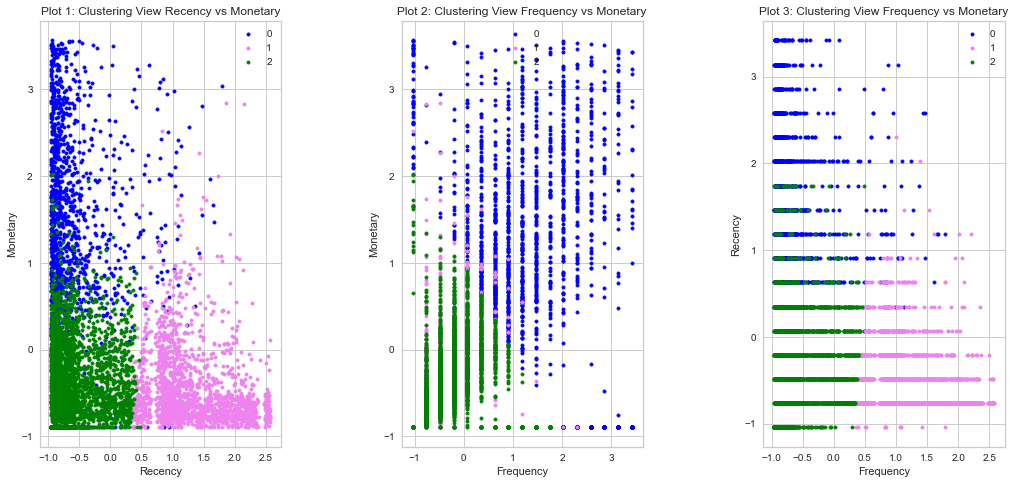

In [42]:
colors=['blue', 'violet','green', 'black','orange','red']
silhouette = calculate_silhouette_score("KMeans",3,3,rfm_df_sc,'','')
plot_clusters_with_centers("KMeans", rfm_df_sc,3,'','')

C:\Users\wuest\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


[ 0.01253072  0.30170173 -0.11191656 ...  0.62494108  0.52083198
  0.41925741]
Silhoutte score: 0.43216645667476716


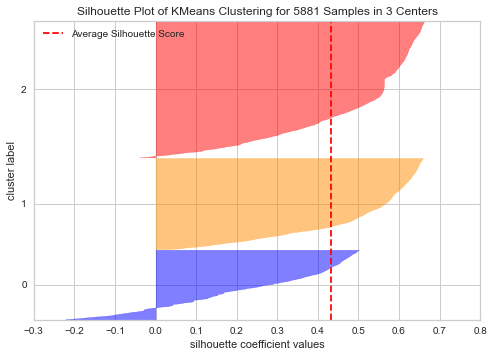

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5881 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [43]:
colors=['blue', 'darkorange','red', 'black','orange','green']
silhouette = calculate_silhouette_score("KMeans",3,3,rfm_df_sc,'','')
kmeans= calculate_kmeans(rfm_df_sc,3)
visualize_silhouette_score(kmeans,colors,rfm_df_sc)

The distribution of the number of the three clusters is very similar. No clusters with a very low or very high number can be identified.

In [44]:
kmeans= calculate_kmeans(rfm_df_sc,3)
rfm_df_copy["cluster"] = kmeans.labels_
evaluation_df.iloc[0,4] = [np.array(rfm_df_copy, dtype=object)]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

2    2695
1    1808
0    1378
Name: cluster, dtype: int64


The boxplots of the three features show different behaviours of customers. The first cluster (k=0) describes customers with a high frequency, a high turnover and a low recency. From a company's point of view, these are very good customers. The second cluster (k=1) describes customers with a low frequency, a low turnover and a high recency. These customers have not bought anything for a long time and must be motivated to buy. The last cluster (k=2) describes customers with a low frequency, a low turnover and a low recency. From the entrepreneur's point of view, these are average customers because they buy regularly. <br>
In all three clusterings you can see in the boxplots that there are outliers. This indicates that a better classification can be achieved with a higher number of clusters. 

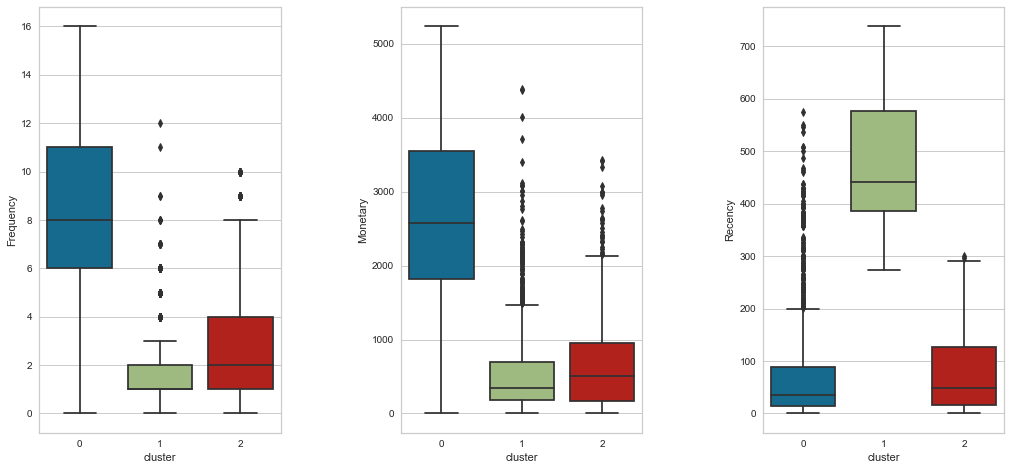

In [45]:
# Boxplots for all Features
create_boxplot(rfm_df_copy)

### Experiment K-Means cluster size k=5 <a id='6'></a> 
The next experiment should be carried out for the K-Means algorithm with cluster size = 5, because it has the second highest silhouette score with k=2. <br>
In addition, it can be guessed from the previous experiment that an increase in cluster size promises a better structure of the clusters. <br>
In the first plot, by increasing the cluster size to 5, a good structure of clusters can be observed. Only cluster 0 overlaps with other clusters. <br>
Plot 2 also shows a good cluster structure with the exception of cluster 1. The plot 3 does not show a clear cluster structure. In the following boxplots, the clusters created are examined in relation to customer segmentation.


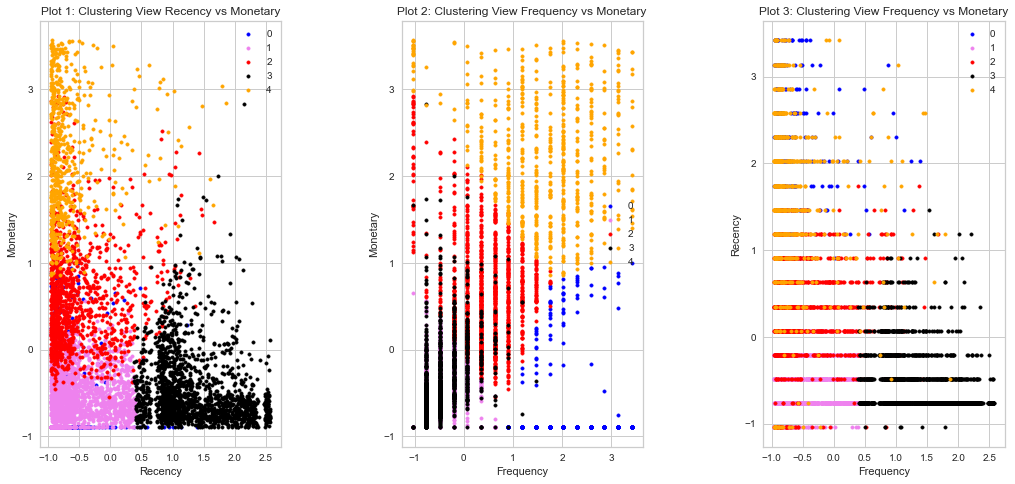

In [46]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("KMeans",5,5,rfm_df_sc,'','')
plot_clusters_with_centers("KMeans", rfm_df_sc,5,'','')

In the silhouette plot, it can see how good the classification was for each cluster. It becomes clear that clusters 2,3,4,0 also have negative silhouette scores. This indicates poor classification.

C:\Users\wuest\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


[0.42334741 0.30695394 0.48295288 ... 0.62714784 0.52153444 0.38430065]
Silhoutte score: 0.4217277040653359


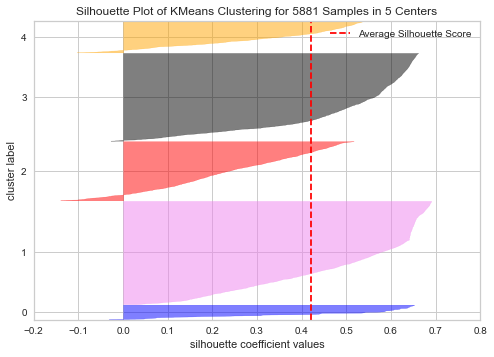

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 5881 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [47]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("KMeans",5,5,rfm_df_sc,'','')
kmeans= calculate_kmeans(rfm_df_sc,5)
visualize_silhouette_score(kmeans,colors,rfm_df_sc)

The distribution of the number of data points in the clusters is no longer balanced. Clusters 0 &4 have significantly fewer data points. 

In [48]:
kmeans= calculate_kmeans(rfm_df_sc,5)
rfm_df_copy["cluster"] = kmeans.labels_
#evaluation_df.iloc[1,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

1    2052
3    1744
2    1176
4     617
0     292
Name: cluster, dtype: int64


The boxplots of the three features show different behaviours of customers. <br>
The first cluster (k=0) describes a customer with a high frequency, a low turnover and a low recency.  From an entrepreneurial point of view, this describes Average customers who frequently and regularly buy small quantities of items and thus only generate low sales. The second cluster (k=1) describes customers with a low frequency, a low turnover and a medium to low recency. This type of customer can be classified as an occasional customer. The third cluster (k=3) describes customers with a medium frequency, a medium turnover and a medium to low recency. These types of customers can be classified as growth customers. The fourth cluster (k=3) describes customers with a low frequency, a low turnover and a high recency. This type of customer can be segmented as inactive customers because they no longer actively shop in the shop. The last cluster (k=4) describes customers who have a high frequency, a high turnover and a low recency. This type of customer can be described as a top customer because they make regular, frequent and high sales.

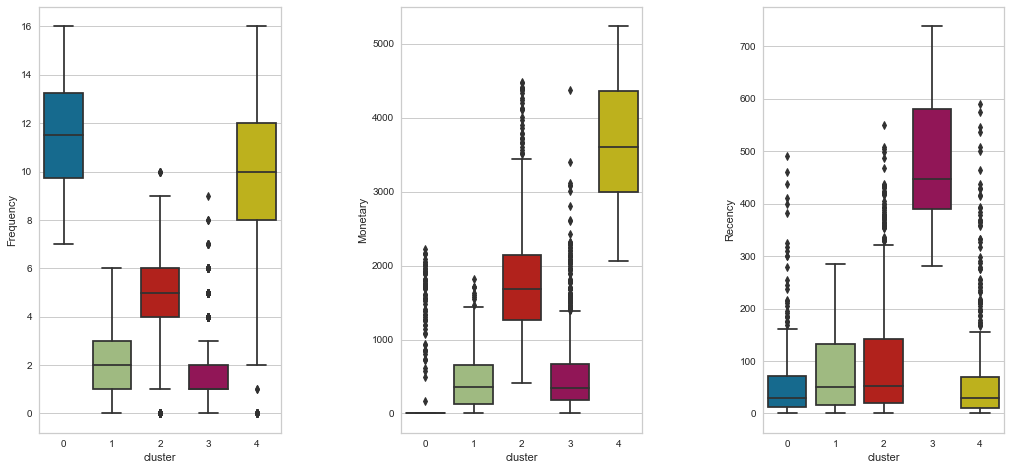

In [49]:
create_boxplot(rfm_df_copy)

## Hierarchical Clustering <a id='7'></a> 
Agglomerative hierarchical clustering  can be characterized as a greedy algorithm. The disired data structure is build thorugh a sequence of irreversible algorithm steps. The algorithm works according to the following rules: In the first step, an initial 1-element cluster is created and pairwise distances are determined. In the second step, the two clusters with the lowest distance to each other are defined as one cluster. In the third step, the distances of all clusters with the new cluster are determined. When all elements are in the new cluster, the algorithm stops. If this is not the case, we go back to step 2 and repeat the following steps.[5] <br>
In the following, different types of hierarchical clustering are compared with each other. The single linkage hierarchical clustering approach outputs a set of clusters (to use graph theoretic terminology, a set of maximal connected subgraphs) at each level—or for each threshold value which produces a new partition. The complete linkage clustering approach takes the maximal distance between two points where each point belongs to each cluster from the pair of clusters.[6] The last linkage criteria is Ward criteria. Therefore the decision of merging the pair of clusters is based on an optimal value of an objective function. In the following the error sum of squares is used as an objective function, also known as Ward's minimum variance method. [8]
The best result for the different linkage criteria is to be found out with the help of different distance functions. For this purpose, the Euclidean, the Manhattan and the Cosine distance functions are examined.
The results obtained can be displayed in a dendogram. The dendogram shows the relationships of the data. It serves as a simple way of recognising groupings and patterns in data. The resulted dendograms should be used to determine the cluster size. <br>
The following 7 dendograms show the different combinations of linkage and distance functions. For clarification of clusters I have defined a cluster size of 5, which represents the clusters in colour. I chose a cluster size of 5 because a good classification was visible in the K-Mean. It should be mentioned that the number of defined clusters has no effect on the creation of the dendogram. In addition, each cluster has a fixed colour. The definition of the colours is defined as: cluster 0 red, cluster 1 green, cluster 2 blue, cluster 3 violet and cluster 4 orange. <br>
Dendogram 1 shows hierarchical clustering for the linkage complete with the euclidean distance function. The chosen colouring of 5 clusters already shows a good structure at first glance. On closer inspection, a cluster size of 3 can be assumed to be the best. A negative aspect is that there are a large number of data points in a cluster. For later customer segregation, it would represent a generalisation of the customers. <br>
Dendogram 2 shows hierarchical clustering for the linkage complete with the Manhattan distance function. The chosen colouring of 5 clusters turns out to be poor. The optimal cluster size can be defined as 2 or 4. <br>
Dendogram 3 shows hierarchical clustering for the linkage complete with the cosine distance function. The chosen colouring of 5 clusters proves to be optimal. Five uniformly sized structures can be recognised. <br>
Dendograms 4, 5 & 6 show the experiments of Hierarchical Clustering with different distance functions. Both dendograms show no structure and cannot be considered for clustering. <br>
Dendogram 7 shows hierarchical clustering for the linkage ward with the euclidean distance function. As an optimal cluster size, 4 clusters can be recognised. <br>
As a summary of the dendograms, it can be stated that the results of the linkage type single do not need to be considered further. The promising dendogram results should be used for further investigation. In the following, hierarchical clustering for linkage complete and Manhattan with cluster size 2 & 4, for linkage complete and Cosine with cluster size 5 and for linkage ward and euclidean with cluster size 4 will be examined. For further consideration, the hierarchical clustering for linkage complete and euclidean is neglected because almost all elements have been assigned to a cluster.


Cluster distribution:
Distance euclidean and Linkage complete
2    4332
0     688
1     547
3     262
4      52
Name: cluster, dtype: int64


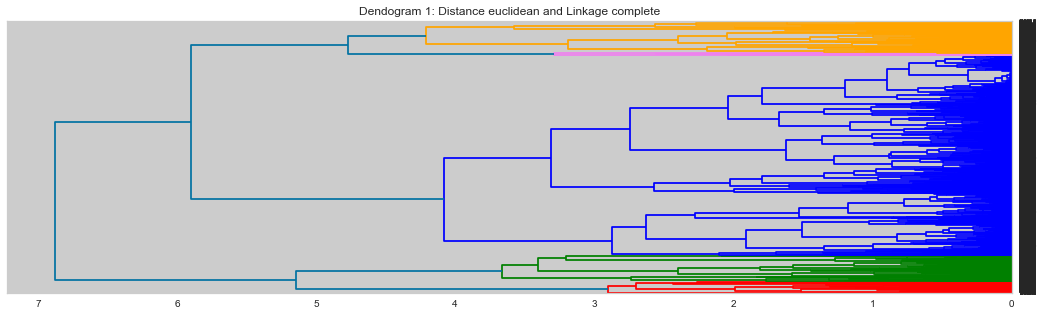

Cluster distribution:
Distance manhattan and Linkage complete
2    2470
0    2294
1     563
3     345
4     209
Name: cluster, dtype: int64


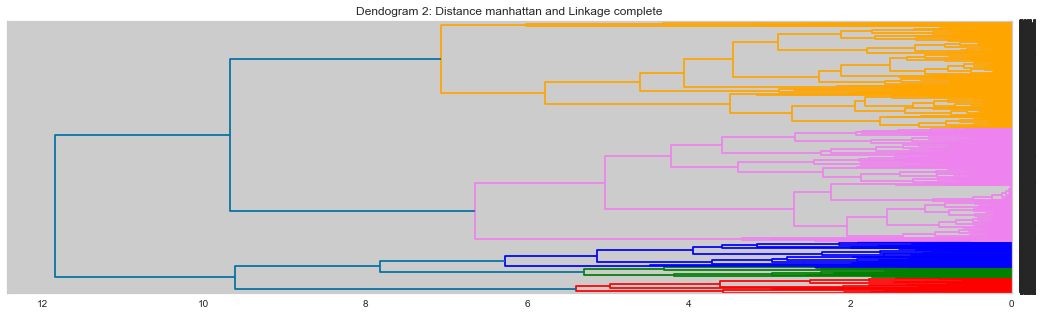

Cluster distribution:
Distance cosine and Linkage complete
3    1763
1    1226
0    1144
4     921
2     827
Name: cluster, dtype: int64


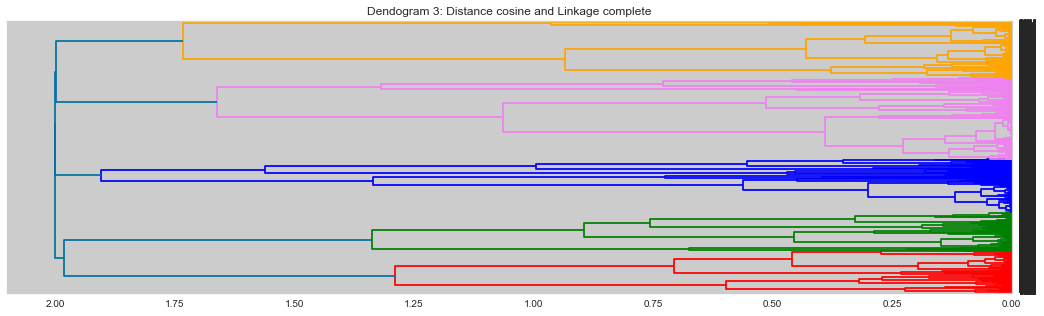

Cluster distribution:
Distance euclidean and Linkage single
0    5876
1       2
4       1
2       1
3       1
Name: cluster, dtype: int64


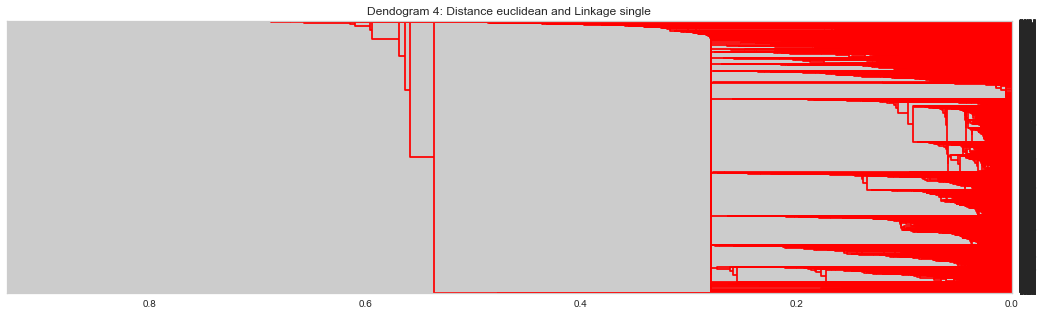

Cluster distribution:
Distance manhattan and Linkage single
0    5876
1       2
3       1
2       1
4       1
Name: cluster, dtype: int64


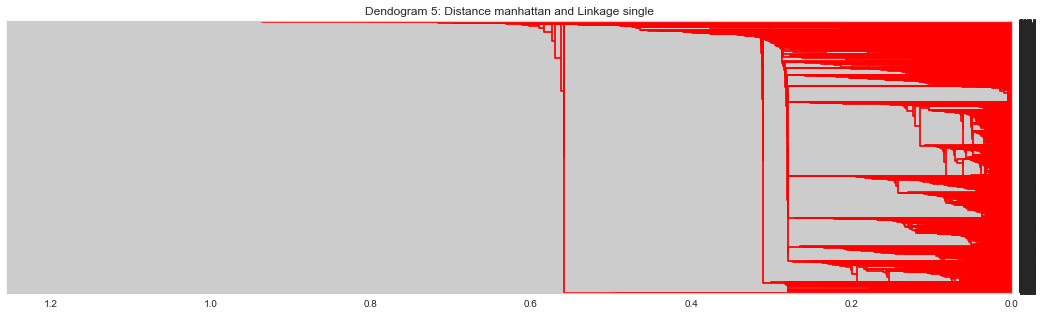

Cluster distribution:
Distance cosine and Linkage single
0    5858
1      10
4       8
2       3
3       2
Name: cluster, dtype: int64


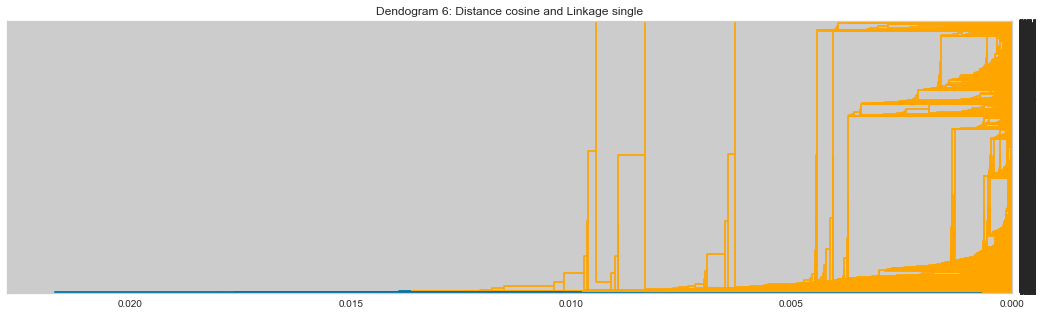

Cluster distribution:
Distance euclidean and Linkage ward
2    2372
0    1878
1     813
3     642
4     176
Name: cluster, dtype: int64


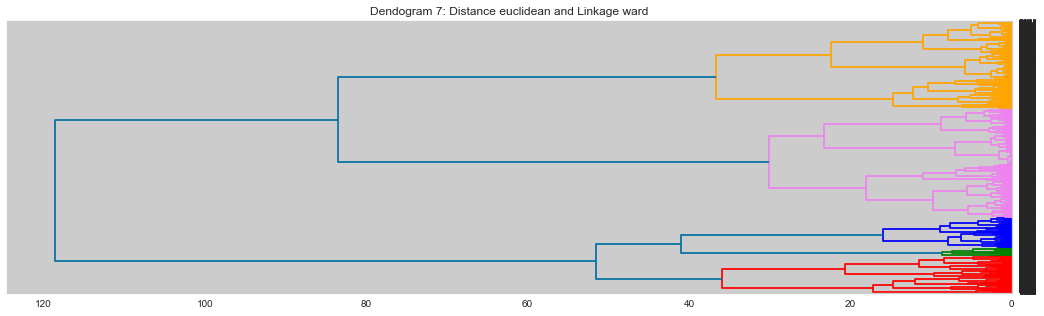

In [57]:
i=0
for linkage in ["complete", "single", "ward"]:
    if linkage == "ward":
        i = i+1
        show_dendogram("euclidean",5,linkage, rfm_df_sc,i)
        break
    else:
        for measure in ["euclidean","manhattan","cosine"]:
            i = i+1
            show_dendogram(measure,5,linkage, rfm_df_sc,i)

In [ ]:
#evaluation_hier_df = pd.DataFrame({'Clustering':[],'Linkage':[], 'Measure':[],'Cluster_size':[] ,'silhouette_score':[],'best_cluster_size':[], 'second_best_size':[]})

In [ ]:
#type_group_df = evaluation_hier_df.groupby(["Linkage", "Measure"], group_keys=False).apply(pd.DataFrame.nlargest,n=2,columns='silhouette_score')

In [ ]:
#type_group_df

In [61]:
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Hierarchical Clustering'], 'silhouette_score':[0.394], 'best_cluster_size':[2], 'cluster_size':[2]}),ignore_index=True)
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Hierarchical Clustering'], 'silhouette_score':[0.370], 'best_cluster_size':[2], 'cluster_size':[4]}),ignore_index=True)

### Experiment Hierarchical Clustering linkage complete and manhattan distance cluster size = 2<a id='8'></a> 
From the previous dendograms, a good cluster size of 2 is achieved for Hierarchical Clustering linkage complete and manhattan distance. This experiment shows the results.<br> 
The three figures show the clustered data. A clear clustering structure can be seen for plots 1&2. Only in plot 1 do data points overlap in certain areas. But in general, a clustering structure can also be recognised in this plot.

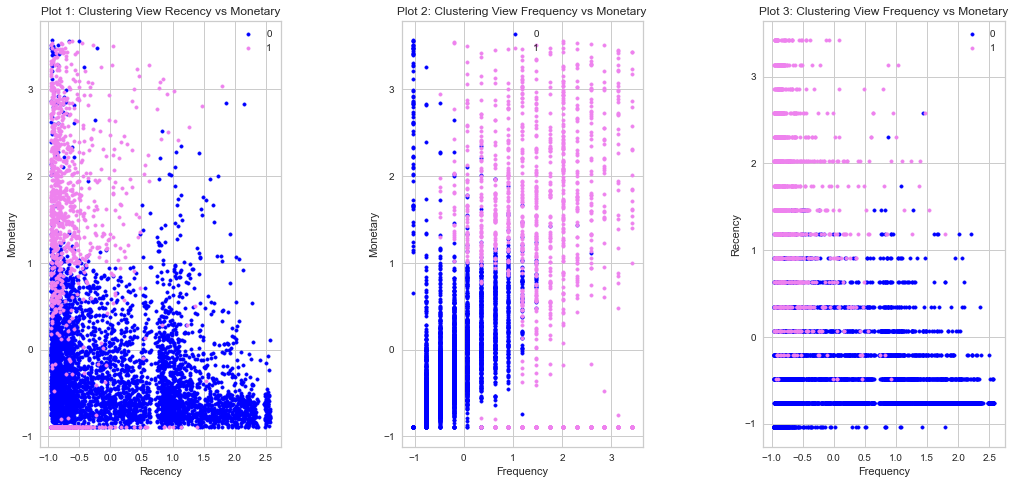

In [59]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("agg",2,2,rfm_df_sc,"manhattan", 'complete')
plot_clusters_with_centers("agg", rfm_df_sc,2,"manhattan", 'complete')

The distribution of the number of clusters shows that the majority of data is in cluster 0.

In [43]:
agg= calculate_hierach_cluster(rfm_df_sc,2,'manhattan', 'complete')
rfm_df_copy["cluster"] = agg.labels_
#evaluation_df.iloc[2,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

0    4764
1    1117
Name: cluster, dtype: int64


The boxplots of the three features show different behaviours of customers. <br>
In general, the division into 2 clusters means that a subdivision can be established in each plot. Cluster 0 is characterised by customers who do not shop frequently, have a low turnover and have not shopped for a long time. It should be noted that the boxplot for recency shows that cluster 0 has a high interquartile range. For the consideration of customer segmentation, it means that a generalisation of customers takes place and thus it can no longer be guaranteed that an individual marketing campaign can take place. <br>
Cluster 1 has a high frequency, a high turnover and a low recency. This cluster represents a top customer. <br>
In summary, clustering with cluster size 2 does not form a good customer segmentation, as cluster 0 is too general in the area of recency, which is due to the high interquartile range. A higher number of cluster sizes promises a better and individual customer segmentation.

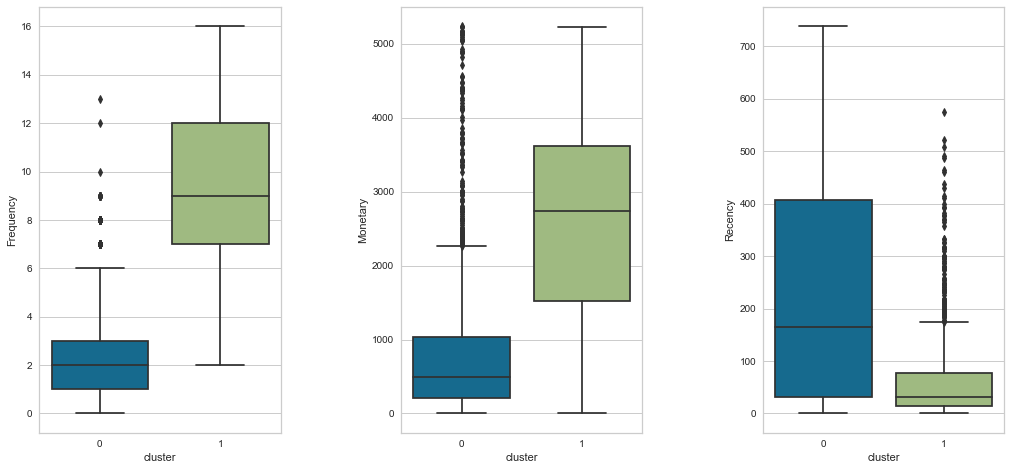

In [44]:
create_boxplot(rfm_df_copy)

### Experiment Hierarchical Clustering linkage complete and manhattan distance cluster size = 4<a id='9'></a> 

The previous experiment showed that a cluster size of 2 cannot guarantee an individual marketing campaign. Therefore, the next experiment will keep the linkage type and the distance function and increase the number of clusters to 4. This cluster size was also clear from the dendogram. <br>
The following three plots show the clustered data based on the three features. In the first plot, a clustering structure is visible, except for cluster 3. In figure 2, a clustering structure is again visible. This time, cluster 1 is the exception. In the third plot, a clustering structure can again be seen. Here, only cluster 0 is the exception. Since the exceptions in each plot differ from the cluster, it can be assumed that a good clustering structure is visible in the following boxplot.

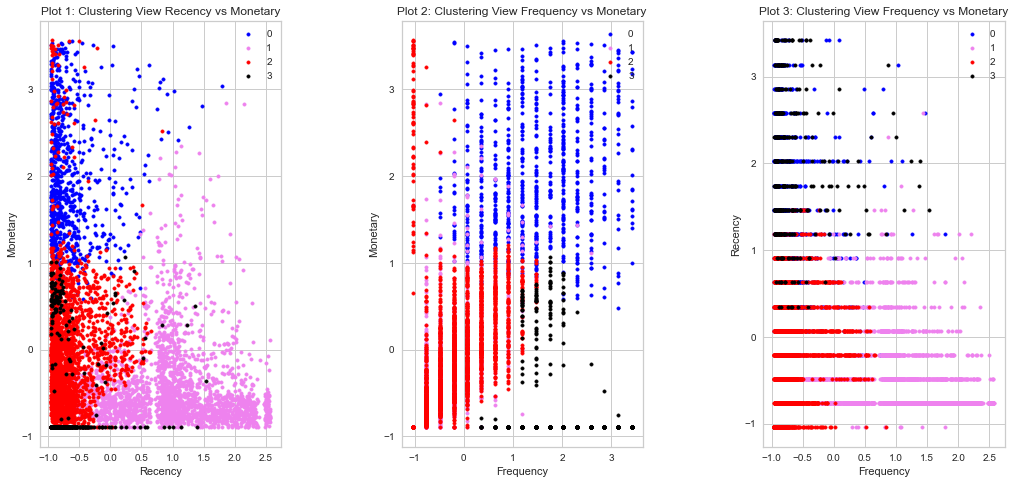

In [60]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("agg",4,4,rfm_df_sc,'manhattan', 'complete')
plot_clusters_with_centers("agg", rfm_df_sc,4, 'manhattan', 'complete')

The distribution of the number of clusters shows that in two clusters are the majority of data.

In [47]:
agg= calculate_hierach_cluster(rfm_df_sc,4,'manhattan', 'complete')
rfm_df_copy["cluster"] = agg.labels_
#evaluation_df.iloc[3,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

2    2470
1    2294
0     772
3     345
Name: cluster, dtype: int64


The boxplots of the three features show different behaviours of customers. <br>
The first cluster (k=0) describes a customer with a high frequency, a high turnover and a low recency.  From an entrepreneurial point of view, this describes Average customers who frequently and regularly buy small quantities of items and thus only generate low sales. The second cluster (k=1) describes customers with a low frequency, a low turnover and a high recency recency. This type of customer can be classified as an occasional customer. The third cluster (k=2) describes customers with a medium frequency, a medium turnover and a low recency. These types of customers can be classified as growth customers. The fourth cluster (k=3) describes customers with a high frequency, a midle to low turnover and a low recency. This type of customer can be segmented as inactive customers because they no longer actively shop in the shop. The last cluster (k=4) describes customers who have a high frequency, a high turnover and a low recency. This type of customer can be described as a top customer because they make regular, frequent and high sales.

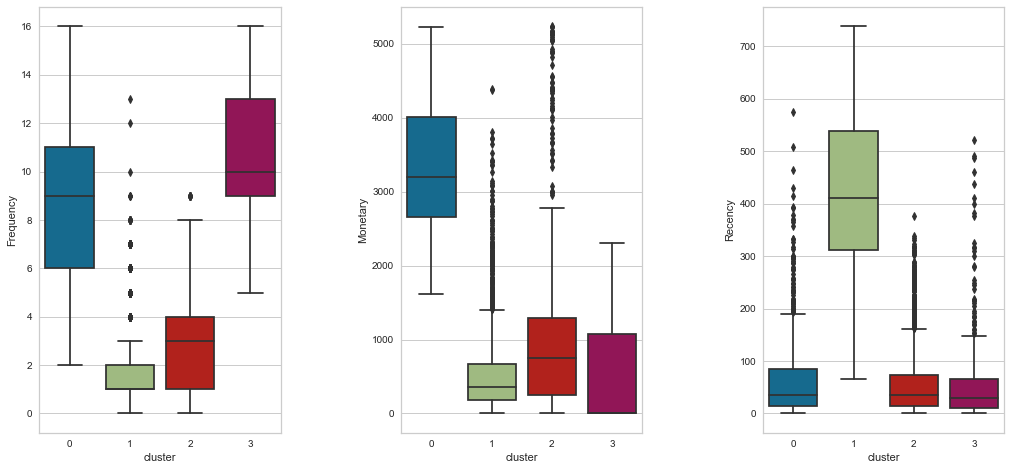

In [48]:
create_boxplot(rfm_df_copy)

### Experiment Hierarchical Clustering linkage complete and cosine distance cluster size = 5<a id='9'></a> 
From the dendograms, hierarchical clustering with the linkage complete and the distance function cosine with cluster size 5 proved to be promising. <br>
The following three plots show the clustered data based on the three features. The first diagram shows a good structure for all clusters except cluster 2. Plot 2 shows a good structure for all clusters except cluster 0. In the third plot, no structure can generally be discerned for the clusters only, as there are many points lying on top of each other.

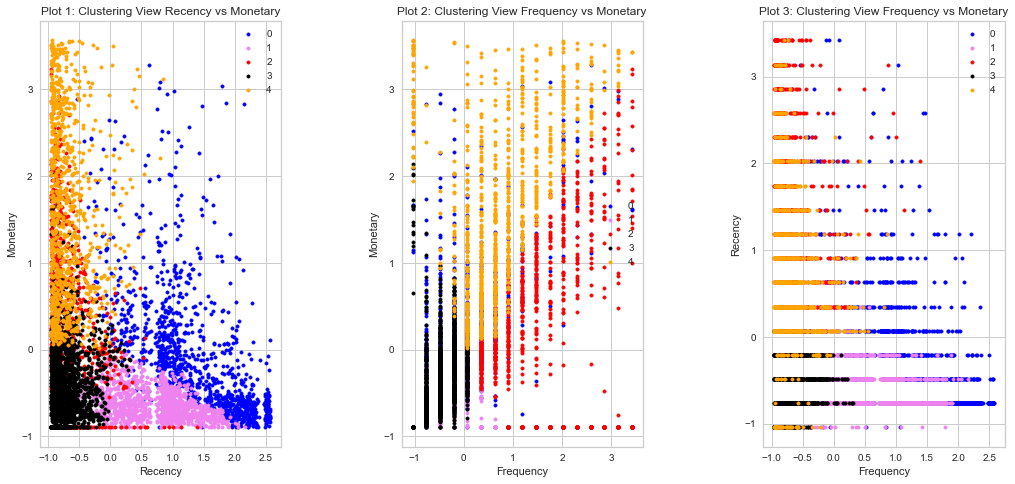

In [61]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("agg",5,5,rfm_df_sc,'cosine', 'complete')
plot_clusters_with_centers("agg", rfm_df_sc,5, 'cosine', 'complete')

The distribution of data points in the clusters is very balanced.

In [51]:
agg= calculate_hierach_cluster(rfm_df_sc,5,'cosine', 'complete')
rfm_df_copy["cluster"] = agg.labels_
#evaluation_df.iloc[3,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

3    1763
1    1226
0    1144
4     921
2     827
Name: cluster, dtype: int64


The boxplots of the three features show different behaviours of customers. <br>
The first cluster (k=0) describes a customer with a low to middle frequency, a middle turnover and a high recency.  From an entrepreneurial point of view, this describes Average customers who frequently and regularly buy small quantities of items and thus only generate low sales. The second cluster (k=1) describes customers with a low frequency, a low turnover and a high recency. This type of customer can be classified as an occasional customer. The third cluster (k=2) describes customers with a high frequency, a medium turnover and a low recency. These types of customers can be classified as growth customers. The fourth cluster (k=3) describes customers with a low frequency, a  low turnover and a low recency. This type of customer can be segmented as inactive customers because they no longer actively shop in the shop. The last cluster (k=4) describes customers who have a midle frequency, a high turnover and a low recency. This type of customer can be described as a top customer because they make regular, frequent and high sales.

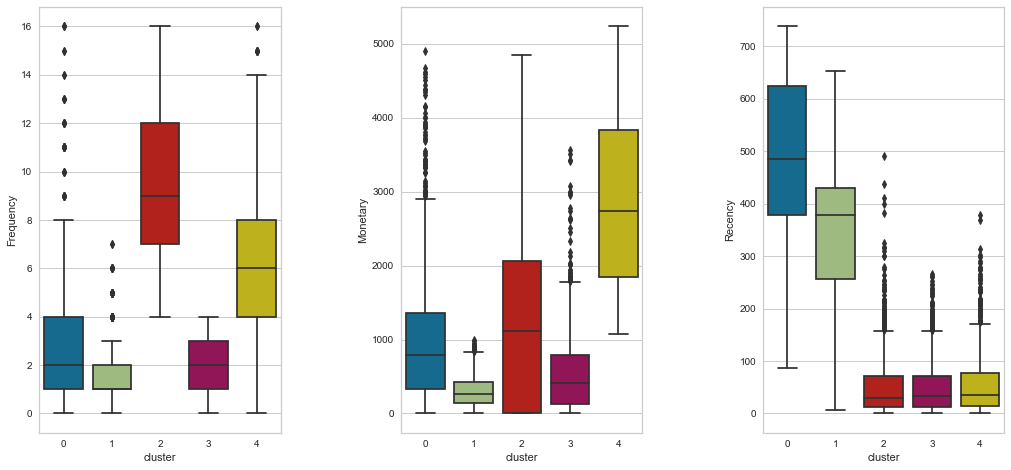

In [52]:
create_boxplot(rfm_df_copy)

### Experiment Hierarchical Clustering linkage ward and euclidean distance cluster size = 4<a id='9'></a> 
From the dendograms, hierarchical clustering with the linkage ward and the distance function euclidean with cluster size 4 proved to be promising. <br>
The following three plots show the clustered data based on the three features. The first diagram shows a good structure for all clusters except of cluster 0. Plot 2 shows a good clustering structure for all clusters except cluster 1. The third diagram shows a good structure for all clusters except of cluster 0.

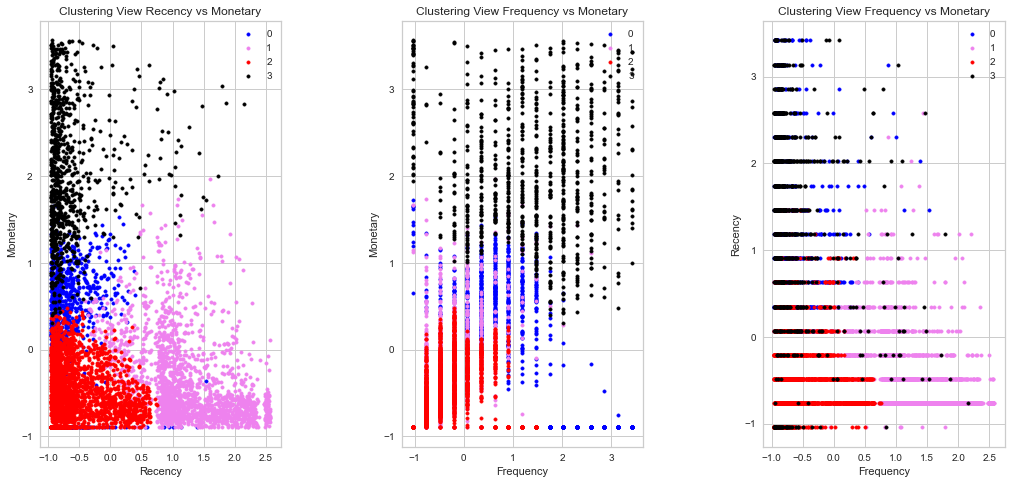

In [53]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("agg",4,4,rfm_df_sc,'euclidean', 'ward')
plot_clusters_with_centers("agg", rfm_df_sc,4, 'euclidean', 'ward')

The distribution of the number of clusters shows that in two clusters are the majority of data.

In [54]:
agg= calculate_hierach_cluster(rfm_df_sc,4,'euclidean', 'ward')
rfm_df_copy["cluster"] = agg.labels_
#evaluation_df.iloc[3,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

2    2372
1    1878
0     818
3     813
Name: cluster, dtype: int64


The boxplots of the three features show different behaviours of customers. <br>
The first cluster (k=0) describes a customer with a middle to high frequency, a middle turnover and a low recency.  From an entrepreneurial point of view, this describes Average customers who frequently and regularly buy small quantities of items and thus only generate low sales. The second cluster (k=1) describes customers with a low frequency, a low turnover and a high recency. This type of customer can be classified as an occasional customer. The third cluster (k=2) describes customers with a low frequency, a low turnover and a low to middle recency. These types of customers can be classified as growth customers. The fourth cluster (k=3) describes customers with a high frequency, a  high turnover and a low recency. This type of customer can be segmented as inactive customers because they no longer actively shop in the shop.

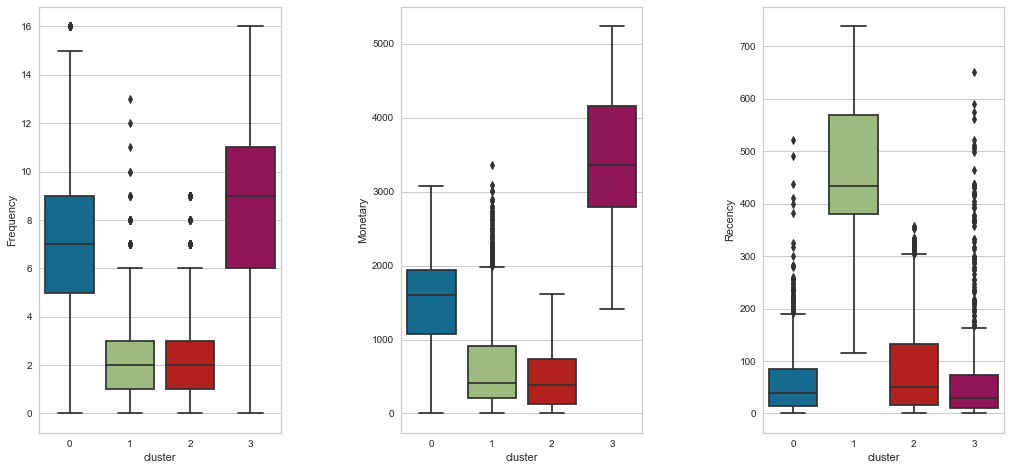

In [55]:
create_boxplot(rfm_df_copy)

## Fuzzy Clustering <a id='10'></a> 
In the final clustering analysis, the RFM data will be examined using fuzzy c-means (FCM) clustering. FCM is an extension of k-Means clustering. The basic idea of FCM can be described as follows: in the first step, the number of clusters is defined, in the second step, cluster centres are randomly defined, in the third step, the objects are then assigned to the clusters, in the fourth step, the cluster centres are recalculated and the objects are assigned. This procedure also corresponds to K-KMeans clustering. The difference can be found in the allocation in FCM, where the objects are allocated with weights. The weights describe the affiliation to the cluster.  In the end, the objects with the highest weight are assigned to the corresponding cluster.[9] <br>
The silhouette coefficient can again be used to determine the cluster size in this algorithm. The plot below shows that the best cluster size is in the range between 2 & 4.

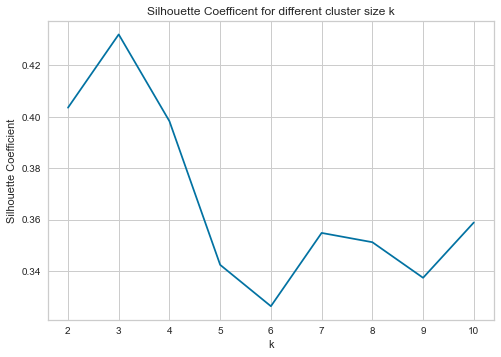

In [84]:
k_min = 2
k_max = 10
evulation,silhouette = calculate_silhouette_score1("fcm",k_min,k_max,rfm_df_sc,'', '')
plot_silhouette_score(k_min,k_max,silhouette)

From the table below, it can be seen that the Silhouette Score is highest for cluster size 3. This is followed by cluster size 2&4, which have a similar value. Since the customers are addressed more individually, a higher cluster size should also be used. Therefore, no experiment is carried out for cluster size 2. For further analysis, cluster size 3 & 4 are examined.

In [92]:
evulation.sort_values(by= "Silhouette Score", ascending = False)

,Clustering,Cluster size,Silhouette Score
1,fcm,3,0.432087
0,fcm,2,0.403569
2,fcm,4,0.398290
8,fcm,10,0.358866
5,fcm,7,0.354804
6,fcm,8,0.351193
3,fcm,5,0.342379
7,fcm,9,0.337338
4,fcm,6,0.326275


In [ ]:
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Fuzzy Clustering'], 'silhouette_score':[0.432], 'best_cluster_size':[3], 'cluster_size':[3]}),ignore_index=True)
evaluation_df = evaluation_df.append(pd.DataFrame({'Clustering':['Fuzzy Clustering'], 'silhouette_score':[0.398], 'best_cluster_size':[3], 'cluster_size':[4]}),ignore_index=True)

### Experiment Fuzzy Clustering Cluster size k=3 <a id='11'></a>

0.4320865863449068


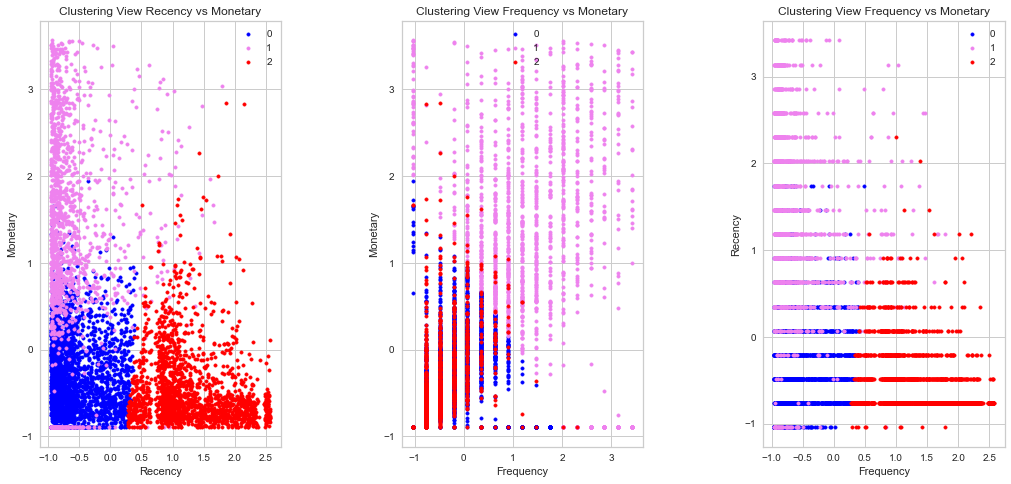

In [ ]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("fcm",3,3,rfm_df_sc,'', '')
plot_clusters_with_centers("fcm", rfm_df_sc,3, '', '')

In [ ]:
rfm_df_copy["cluster"] = calculate_fcm_cluster(rfm_df_sc,3)
evaluation_df.iloc[4,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

2    2677
0    1860
1    1344
Name: cluster, dtype: int64


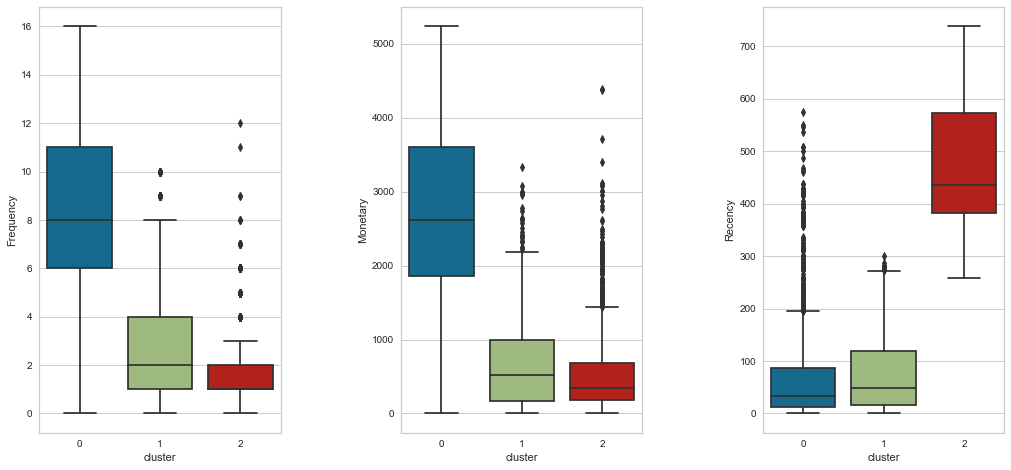

In [ ]:
create_boxplot(rfm_df_copy)


### Experiment Fuzzy Clustering Cluster size k=4 <a id='12'></a>

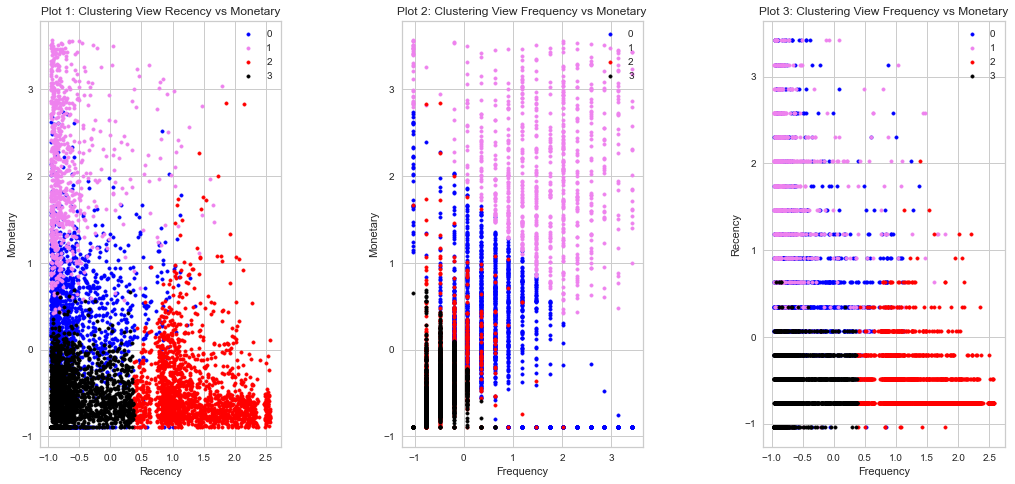

In [86]:
colors=['blue', 'violet','red', 'black','orange','green']
silhouette = calculate_silhouette_score("fcm",4,4,rfm_df_sc,'', '')
plot_clusters_with_centers("fcm", rfm_df_sc,4, '', '')

In [87]:
rfm_df_copy["cluster"] = calculate_fcm_cluster(rfm_df_sc,4)
#evaluation_df.iloc[5,4] = [rfm_df_copy]
distribution = rfm_df_copy['cluster'].value_counts()
print(distribution)

0    1958
2    1756
1    1436
3     731
Name: cluster, dtype: int64


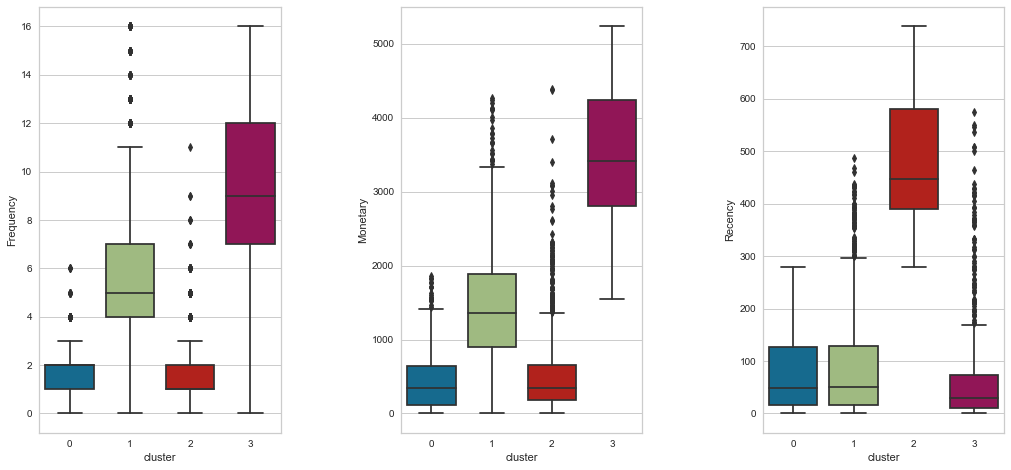

In [88]:
create_boxplot(rfm_df_copy)

## Evaluation <a id='14'></a> 

In [ ]:
evaluation_df

,Clustering,silhouette_score,best_cluster_size,cluster_size,labeled_data
0,K-Means,0.432,3.0,3.0,Recency Frequency Monetary clu...
1,K-Means,0.421,3.0,5.0,Recency Frequency Monetary clu...
2,Hierarchical Clustering,0.394,2.0,2.0,Recency Frequency Monetary clu...
3,Hierarchical Clustering,0.370,2.0,4.0,Recency Frequency Monetary clu...
4,Fuzzy Clustering,0.432,3.0,3.0,Recency Frequency Monetary clu...
5,Fuzzy Clustering,0.403,3.0,2.0,Recency Frequency Monetary clu...
6,Fuzzy Clustering,0.398,3.0,4.0,Recency Frequency Monetary clu...


#### Comparison Cluster size = 2

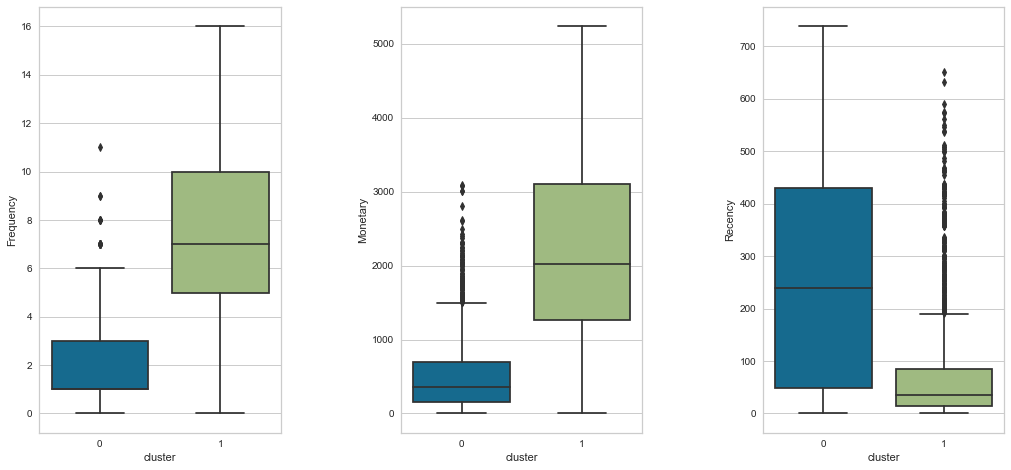

In [ ]:
# Hierarchical Clustering k=2
create_boxplot(pd.DataFrame(evaluation_df.iloc[2][4]))

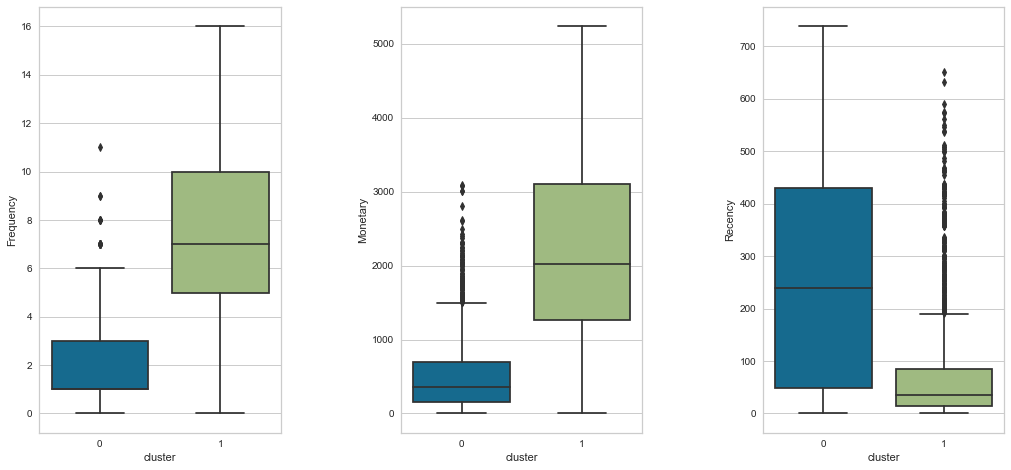

In [ ]:
# Fuzzy Clustering k=2
create_boxplot(pd.DataFrame(evaluation_df.iloc[5][4]))

#### Comparison Cluster size = 3

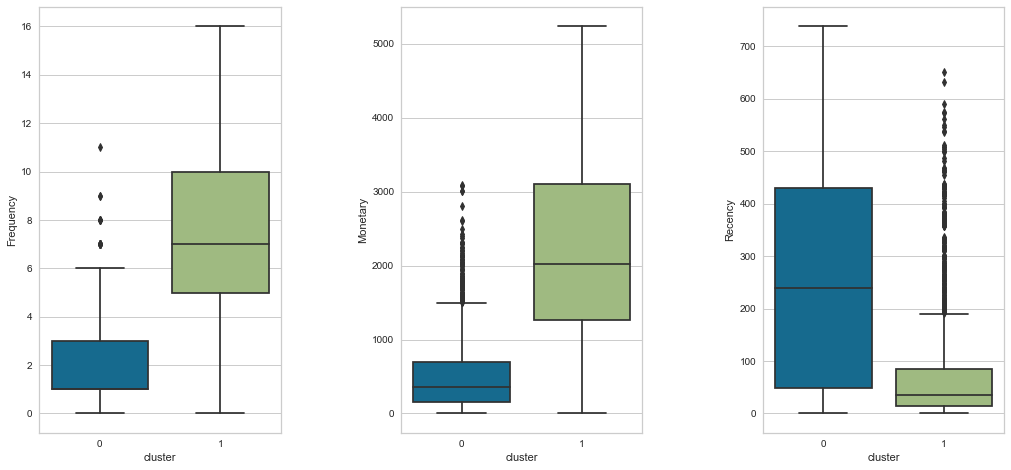

In [ ]:
# KMeans k=3
create_boxplot(pd.DataFrame(evaluation_df.iloc[0][4]))

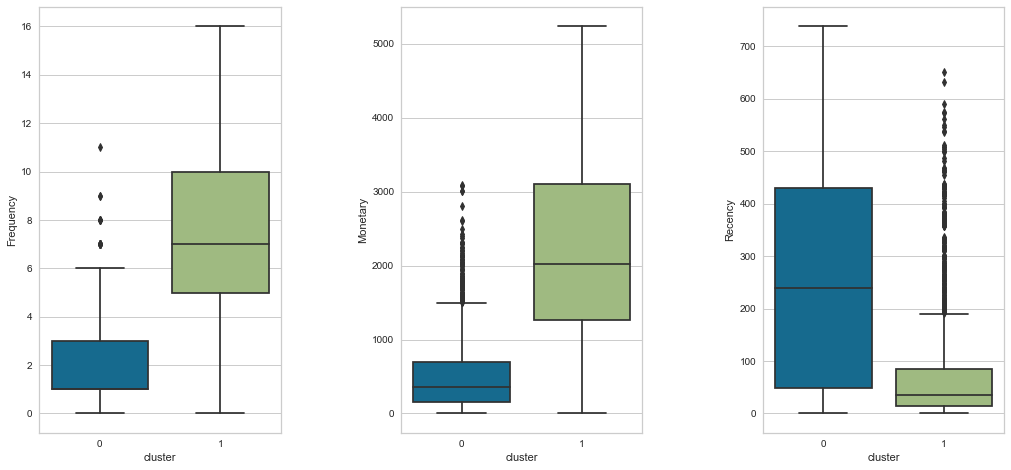

In [ ]:
# Fuzzy Clsutering k=3
create_boxplot(pd.DataFrame(evaluation_df.iloc[4][4]))

#### Comparison Cluster size = 4

In [ ]:
# Hierarchical Clustering k=4
create_boxplot(pd.DataFrame(evaluation_df.iloc[3][4]))

In [ ]:
# Fuzzy Clsutering k=4
create_boxplot(pd.DataFrame(evaluation_df.iloc[6][4]))

#### Comparison Cluster size = 5

In [ ]:
# KMeans k=5
create_boxplot(pd.DataFrame(evaluation_df.iloc[1][4]))

## References

[1]
[2]     Maryani, Ina, et al. "Customer segmentation based on RFM model and clustering techniques with K-means algorithm." 2018 Third International Conference on Informatics and        Computing (ICIC). IEEE, 2018.
[3]     Shirole, Rahul, Laxmiputra Salokhe, and Saraswati Jadhav. "Customer Segmentation using RFM Model and K-Means Clustering." (2021).

[4]     Ramamohan, Y, K Vasantharao, C Kalyana Chakravarti,and a S KRatnam. 2012. “A Study of Data Mining Tools in Knowledge Discovery Process.” International Journal of
        Soft Computing and Engineering 2 (3):191–94.
[5]     Murtagh, Fionn, and Pedro Contreras. "Algorithms for hierarchical clustering: an overview." Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery 2.1 (2012): 86-97.
[6]     Jarman, Angur Mahmud. "Hierarchical Cluster Analysis: Comparison of Single linkage, Complete linkage, Average linkage and Centroid Linkage Method." (2020).
[7]     Biggio, Battista, et al. "Poisoning complete-linkage hierarchical clustering." Joint IAPR International Workshops on Statistical Techniques in Pattern Recognition (SPR) and     Structural and Syntactic Pattern Recognition (SSPR). Springer, Berlin, Heidelberg, 2014.
[8]     Sasirekha, K., and P. Baby. "Agglomerative hierarchical clustering algorithm-a." International Journal of Scientific and Research Publications 83 (2013): 83.
[9]     Safari, Fariba, Narges Safari, and Gholam Ali Montazer. "Customer lifetime value determination based on RFM model." Marketing Intelligence & Planning (2016).
[34]    Peter J. Rousseeuw, Journal of Computational and Applied
        Mathematics, Volume 20, November 1987, Pages 53–65 <br>
[20]    Bholowalia, P., & Kumar, A. (2014). EBK-means: A clustering technique based on elbow method and k-means in WSN. International Journal of Computer Applications, 105(9).